In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader
import time
from datetime import datetime

In [2]:
#导入数据
factor_df=pd.read_csv("/data01/data_for_intern/factor_data_13_19.csv")
return_df=pd.read_csv("/data01/data_for_intern/return_data_13_19.csv")
return_label=return_df.drop(columns=['return_adj_d001','return_adj_d005','car_hs300_b30_d005'])
return_label['car_hs300_b30_d001']=(return_label['car_hs300_b30_d001']>=0)*1
#利用内连接方式合并数据
merged_factor_return = factor_df.merge(return_label,on=["stock_code","trade_date"],how="inner")

In [3]:
#筛选日期节点,以15个交易日为界
date=[]
import datetime
date.append("2013-01-07")
i=0
while(i>-1):
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    if date[i]=="2019-12-02":
        break
    delta=datetime.timedelta(days=28)
    n_days=now+delta
    date.append(n_days.strftime('%Y-%m-%d'))
    i=i+1

In [4]:
date_dict={}
for i in range(len(date)-1):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if now.strftime('%Y-%m-%d') == date[i+1]:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
    date_dict[str(i)] = temp_list

In [5]:
valid_date_dict={}
for i in range(1,len(date)):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    k = 0
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if k>=14:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
        k=k+1
    valid_date_dict[str(i-1)] = temp_list

In [6]:
df_train_dict={}
for i in range(len(date_dict)):
    df_train_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (date_dict[str(i)])]

In [7]:
df_valid_dict={}
for i in range(len(valid_date_dict)):
    df_valid_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (valid_date_dict[str(i)])]

In [8]:
from datetime import datetime
import roll_data
from rolling_window import *

In [9]:
def unroll_data(join_df, gap_day, roll_day, debug=False):
    # 把前后时间差距大的地方切开
    start = time.time()
    
    all_dfs = []
    
    for code, grp in join_df.groupby('stock_code'):
        grp = grp.sort_index()
        split_point = [0]
        for i in range(len(grp.index) - 1):
            if type(grp.index[i][0]) == str:
                current_day = datetime.strptime(grp.index[i+1][0], '%Y-%m-%d')
                pre_day = datetime.strptime(grp.index[i][0], '%Y-%m-%d')
                gap = (current_day - pre_day).days
            else:
                gap = grp.index[i+1][0] - grp.index[i][0]
            if gap > gap_day:
                if debug:
                    print(grp.index[i+1][0])
                    print(grp.index[i][0])
                    print(gap)
                split_point.append(i+1)
        split_point.append(len(grp.index))
    
        for i in range(len(split_point) - 1):
            if split_point[i+1] - split_point[i] > roll_day:
                all_dfs.append(grp.iloc[split_point[i]:split_point[i+1]])
    time_spend = time.time() - start
    print('Filter large gap...\nTime: %.3f'%(time_spend))
    
        # 把数据展开成sequence
    data_list = []
    label_list = []
    index_list = []

    start = time.time()

    for df in all_dfs:
        grp_data = df.sort_index()
        data_fetch = []
        label_fetch = []
        index = []

        for i in range(grp_data.shape[0] - roll_day):
            data_fetch.append(list(range(i, i + roll_day)))
            label_fetch.append(i + roll_day)
            index.append(grp_data.index[i + roll_day])        

        data_fetch = np.array(data_fetch)
        label_fetch = np.array(label_fetch)

        data = np.take(grp_data.values[:, :-1], data_fetch, axis=0)
        #print(data.shape)
        data = np.transpose(data,(0,2,1))
        label = np.take(grp_data.values[:,-1], label_fetch, axis=0)

        index_list = index_list + index
        data_list.append(data)
        label_list.append(label)
    #print(data_list)
    if len(data_list) != 0:
        data_list = np.concatenate(data_list, axis=0)
        label_list = np.concatenate(label_list, axis=0)

    print('Unrolling Data...\nTime: %.3f s'%(time.time() - start))
    
    return index_list, data_list, label_list

In [10]:
from wavenet import *

In [11]:
def wavenet_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)

        num_classes=2 
        in_depth=64 
        in_channels=42 
        skip_channels=64 
        dilation_depth=3 
        device= torch.device("cuda:1")
        batch_size=128
        learning_rate=0.0001
        num_epochs=1000
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = WaveNet(num_classes, in_depth, in_channels, skip_channels, dilation_depth, device)
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 12.016
Unrolling Data...
Time: 6.567 s
Filter large gap...
Time: 13.016
Unrolling Data...
Time: 7.670 s
(16318, 42, 8) (6998, 42, 8)
precision of the model on thetrainingdata: 58.97435760498047%
precision of the model on thevalidationdata: 46.957672119140625%
precision of the model on thetrainingdata: 52.6315803527832%
precision of the model on thevalidationdata: 46.07464599609375%
precision of the model on thetrainingdata: 64.15093994140625%
precision of the model on thevalidationdata: 46.35669708251953%
precision of the model on thetrainingdata: 63.76811599731445%
precision of the model on thevalidationdata: 46.03824996948242%
precision of the model on thetrainingdata: 61.403507232666016%
precision of the model on thevalidationdata: 46.522037506103516%
precision of the model on thetrainingdata: 69.23076629638672%
precision of the model on thevalidationdata: 46.709129333496094%
precision of the model on thetrainingdata: 59.3220329284668%
precis

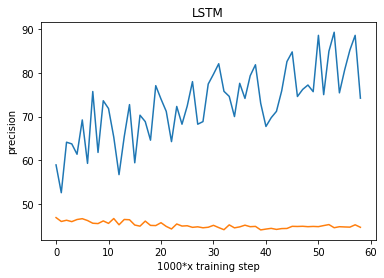

precision of the model on thevalidationdata: 45.15098571777344%
tensor([0.7363, 0.9615, 0.5342, 0.5745, 0.5133, 0.9995, 0.9999, 1.0000, 1.0000,
        0.9439, 1.0000, 1.0000, 0.8787, 0.9467, 1.0000, 1.0000, 1.0000, 0.9814,
        0.7989, 0.9356, 0.5452, 0.8299, 0.9999, 0.9928, 1.0000, 1.0000, 0.8844,
        0.9997, 0.7912, 1.0000, 1.0000, 0.9883, 0.5893, 0.6065, 0.9669, 0.9957,
        0.9997, 1.0000, 0.9977, 0.9830, 1.0000, 0.9974, 0.7268, 0.9631, 0.9763,
        0.7396, 0.9999, 0.9933, 0.9494, 0.5041, 0.9060, 0.9180, 0.9220, 1.0000,
        0.9998, 0.9851, 0.9969, 0.6960, 0.5430, 0.9057, 0.9817, 0.5617, 0.8163,
        0.8449, 0.9105, 0.6262, 0.5055, 0.7006, 1.0000, 0.6266, 0.9521, 0.5917,
        1.0000, 0.9980, 1.0000, 0.9299, 0.6876, 0.7777, 0.9739, 1.0000, 0.5101,
        0.9123, 0.9992, 0.9363, 1.0000, 0.9935, 0.9915, 0.8250, 0.9496, 0.5226,
        0.9696, 0.9770, 1.0000, 0.9882, 0.9889, 1.0000, 1.0000, 0.7395, 0.5436,
        0.8048], device='cuda:1')
current i is 2
Filter 

precision of the model on thetrainingdata: 71.15384674072266%
precision of the model on thevalidationdata: 60.40330123901367%
precision of the model on thetrainingdata: 86.20689392089844%
precision of the model on thevalidationdata: 61.59769058227539%


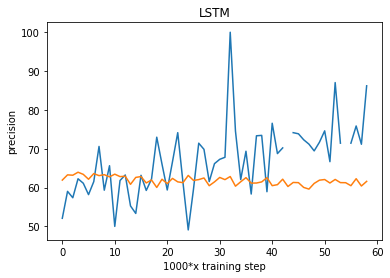

precision of the model on thevalidationdata: 61.06804656982422%
tensor([0.9996, 0.9878, 0.5409, 0.5715, 0.5417, 0.8766, 0.5956, 0.5398, 0.9732,
        0.5411, 0.5149, 0.6525, 0.5026, 0.5659, 0.9952, 0.7594, 0.5594, 0.7789,
        0.6490, 0.9885, 0.9561, 0.7513, 0.6193, 0.5131, 0.7594, 0.7200, 0.5600,
        0.6028, 0.5819, 0.9028, 0.7666, 0.9822, 0.6376, 0.6982, 0.5174, 0.6189,
        0.7373, 0.7376, 0.9976, 0.5156, 0.9692, 0.7712, 0.7670, 0.9956, 0.9993,
        0.9698, 0.7523, 0.5028, 0.5154, 0.6876, 0.9999, 0.5960, 0.5112, 0.7135,
        0.9910, 0.5937, 0.8294, 0.6515, 0.6132, 1.0000, 0.5428, 0.7795, 0.8178,
        0.8021, 0.7555, 0.9880, 0.7609, 0.6435, 0.6402, 0.8115, 0.5763, 0.6835,
        0.9876, 0.6896, 0.8096, 0.7543, 0.7808, 0.5486, 0.6041, 0.9949, 0.9974,
        0.5006, 0.6650, 0.8395, 0.9885, 0.7642, 0.9979, 0.9711, 0.5821, 0.9979,
        0.6742, 0.6689, 0.5726, 0.5468, 0.5172, 0.7774, 0.9882, 0.5172, 0.6157,
        0.9512], device='cuda:1')
current i is 3
Filter 

precision of the model on thevalidationdata: 45.58765411376953%
precision of the model on thetrainingdata: 70.12986755371094%
precision of the model on thevalidationdata: 45.07512664794922%
precision of the model on thetrainingdata: 63.6363639831543%
precision of the model on thevalidationdata: 46.03343963623047%
precision of the model on thetrainingdata: 67.532470703125%
precision of the model on thevalidationdata: 44.753326416015625%


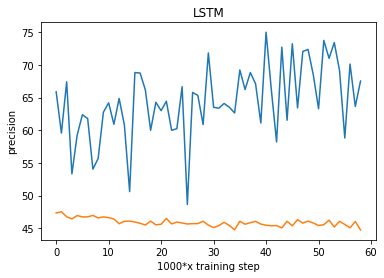

precision of the model on thevalidationdata: 45.95761489868164%
tensor([0.5051, 0.9999, 0.5635, 1.0000, 0.8877, 0.9998, 0.9999, 0.9999, 0.7320,
        0.8515, 1.0000, 0.9530, 0.5222, 0.5707, 0.8490, 1.0000, 0.7522, 0.5843,
        0.6904, 0.8330, 0.8532, 0.8352, 0.9431, 0.5300, 0.6291, 0.9320, 0.7381,
        0.6544, 0.9801, 0.5275, 0.6168, 1.0000, 0.8923, 0.6877, 0.5713, 0.5974,
        0.6829, 0.6762, 0.6599, 0.5289, 0.6822, 0.5697, 0.6029, 0.5505, 0.5763,
        0.6435, 0.9897, 0.8425, 0.9886, 0.6529, 0.6910, 0.9972, 1.0000, 0.7722,
        0.8465, 0.7082, 1.0000, 1.0000, 0.7822, 0.9962, 0.9999, 0.6224, 0.7024,
        0.5418, 0.8000, 0.6743, 0.8720, 0.9819, 0.8124, 0.5267, 0.6537, 0.9163,
        0.7340, 0.5724, 0.6735, 0.7033, 0.9837, 0.8808, 0.9963, 0.6015, 0.5623,
        0.7155, 0.5466, 0.7537, 0.6771, 0.7262, 0.9791, 0.6127, 0.6007, 0.5311,
        0.5686, 0.6629, 0.8709, 0.5425, 0.6428, 0.8178, 0.8222, 0.8246, 0.6465,
        0.5990], device='cuda:1')
current i is 5
Filter 

precision of the model on thetrainingdata: 90.16393280029297%
precision of the model on thevalidationdata: 40.19981002807617%
precision of the model on thetrainingdata: 87.5%
precision of the model on thevalidationdata: 40.38721466064453%


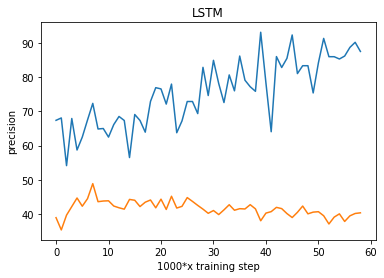

precision of the model on thevalidationdata: 40.51029586791992%
tensor([0.9555, 0.9039, 0.9111, 0.9931, 0.8979, 0.9521, 0.9648, 0.7980, 0.8789,
        0.8745, 0.8594, 0.7462, 0.9938, 0.9941, 0.5554, 0.8397, 0.8338, 0.9491,
        0.9920, 0.6212, 0.9066, 0.6270, 0.5664, 0.8846, 0.6426, 0.9006, 0.7937,
        0.6316, 0.9730, 0.7762, 0.7959, 0.7084, 0.8839, 0.6610, 0.9543, 0.6351,
        0.5967, 0.6640, 0.5118, 0.6868, 0.5540, 0.6339, 0.9971, 0.5462, 0.5649,
        0.5492, 0.5122, 0.6961, 0.9437, 0.5776, 0.6682, 0.6732, 0.6267, 0.6433,
        0.7279, 0.5397, 0.9271, 0.6160, 0.6265, 0.7498, 0.6281, 0.8348, 0.5997,
        0.8842, 0.9372, 0.6104, 0.7922, 0.5484, 0.7264, 0.8797, 0.5859, 0.5461,
        0.7488, 0.9960, 0.6442, 0.8133, 0.6446, 0.6072, 0.8933, 0.8509, 0.6908,
        0.7721, 0.9034, 0.8297, 0.5197, 0.9998, 0.6674, 0.6417, 0.9238, 0.5416,
        0.5007, 0.6329, 0.5152, 0.7819, 0.8809, 0.5295, 0.8824, 0.6024, 0.8752,
        0.9255], device='cuda:1')
current i is 6
Filter 

precision of the model on thetrainingdata: 79.16666412353516%
precision of the model on thevalidationdata: 49.77876281738281%
precision of the model on thetrainingdata: 76.27118682861328%
precision of the model on thevalidationdata: 49.93734359741211%


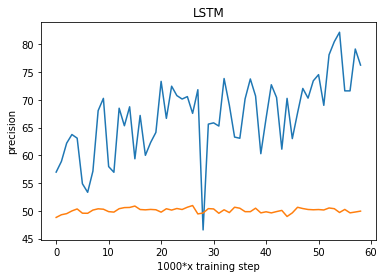

precision of the model on thevalidationdata: 49.48759460449219%
tensor([0.5202, 0.5726, 0.5463, 0.6071, 0.5729, 0.6698, 0.5673, 0.5654, 0.5118,
        0.6755, 0.6304, 0.5136, 0.5778, 0.5162, 0.7905, 0.6409, 0.5513, 0.5604,
        0.8130, 0.7858, 0.6838, 0.8592, 0.5157, 0.6677, 0.9990, 0.6273, 0.6323,
        0.6398, 0.5838, 0.6135, 0.5965, 0.7403, 0.9453, 0.8406, 0.5336, 0.6447,
        0.7536, 0.8537, 0.5586, 0.6696, 0.8759, 0.6071, 0.6464, 0.6580, 0.6055,
        0.9989, 0.6620, 0.5043, 0.8366, 0.5670, 0.5445, 0.5614, 0.7778, 0.5957,
        0.6799, 0.5868, 0.5087, 0.8503, 0.5525, 0.5135, 0.9934, 0.7730, 0.6716,
        0.9999, 0.8603, 0.7482, 0.5894, 0.8913, 0.5371, 0.5051, 0.5694, 0.7023,
        0.9737, 0.5664, 0.5211, 0.5422, 0.6273, 0.5538, 0.5743, 0.5833, 0.5615,
        0.6490, 0.7976, 0.5933, 0.7424, 0.6444, 0.7565, 0.6871, 0.7471, 0.6604,
        0.6075, 0.5614, 0.6849, 0.6224, 0.5089, 0.6535, 0.5962, 0.5475, 0.7232,
        0.5332], device='cuda:1')
current i is 7
Filter 

precision of the model on thevalidationdata: 48.30477523803711%
precision of the model on thetrainingdata: 60.52631759643555%
precision of the model on thevalidationdata: 48.36252975463867%


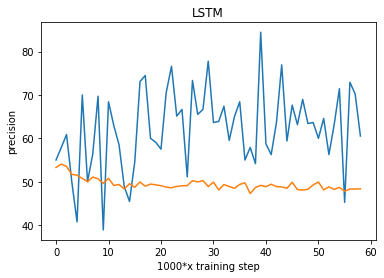

precision of the model on thevalidationdata: 49.31714630126953%
tensor([0.5877, 0.5855, 0.6091, 1.0000, 1.0000, 0.9994, 0.7933, 0.7334, 0.6812,
        0.6190, 0.5421, 0.5794, 0.7457, 0.6011, 0.5838, 0.5446, 0.6020, 0.6443,
        0.9859, 0.9999, 1.0000, 0.8100, 0.9365, 0.9995, 0.5212, 0.5877, 0.5287,
        0.9999, 0.9466, 1.0000, 0.6800, 0.5203, 0.5931, 1.0000, 0.9958, 0.5117,
        0.5875, 0.7134, 0.5463, 0.6368, 0.6745, 0.6829, 0.6203, 0.7274, 0.5728,
        0.8009, 0.5294, 0.5385, 0.5196, 0.6349, 0.5768, 0.7294, 0.7438, 0.5963,
        0.6832, 0.5024, 0.5880, 0.6933, 0.5244, 0.5453, 0.6175, 0.6416, 0.5386,
        0.5096, 0.6452, 0.5284, 0.6578, 0.5355, 0.5095, 0.6490, 0.5501, 0.6100,
        0.5486, 0.7390, 0.5982, 0.6870, 0.7362, 0.9440, 0.5131, 0.6701, 0.7302,
        0.5277, 0.5136, 0.5421, 0.6378, 0.5651, 0.5455, 0.6257, 0.8942, 0.5512,
        0.6540, 0.7124, 0.5162, 0.6791, 0.5172, 0.5583, 0.5515, 0.5783, 0.5129,
        0.5949], device='cuda:1')
current i is 8
Filter 

precision of the model on thetrainingdata: 73.91304016113281%
precision of the model on thevalidationdata: 63.821533203125%
precision of the model on thetrainingdata: 72.97297668457031%
precision of the model on thevalidationdata: 62.127235412597656%


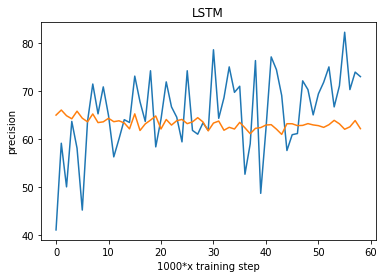

precision of the model on thevalidationdata: 62.345088958740234%
tensor([0.7436, 1.0000, 0.6887, 0.8274, 0.9857, 0.9794, 0.7615, 0.5180, 0.9997,
        1.0000, 0.9181, 0.9976, 0.5127, 0.8560, 0.5826, 0.7982, 0.8669, 0.8101,
        0.7626, 0.9974, 0.6585, 0.9852, 0.9288, 0.9004, 0.5730, 0.7134, 0.8600,
        0.6343, 0.8112, 0.9803, 0.6302, 0.9999, 0.7560, 0.9998, 0.8069, 0.8183,
        0.5392, 0.5135, 0.5743, 0.5070, 0.9965, 0.6054, 0.5999, 0.5822, 0.9999,
        0.6355, 0.9740, 0.8805, 0.7900, 0.9111, 0.5959, 0.9999, 0.8188, 1.0000,
        0.9620, 0.6232, 0.9946, 0.6572, 0.7974, 0.8598, 0.7156, 0.7382, 0.6154,
        0.9187, 0.9638, 0.7253, 0.9992, 0.5914, 0.9636, 0.6372, 0.7684, 0.9999,
        0.5095, 0.6060, 0.8357, 0.6206, 0.7055, 0.8426, 0.5331, 0.6103, 0.9919,
        0.5977, 0.9991, 0.8318, 0.9001, 0.8749, 0.9046, 0.6029, 0.7042, 0.5400,
        0.7852, 0.5046, 0.6948, 0.5197, 0.9938, 0.7856, 0.6755, 0.8500, 0.7008,
        0.8048], device='cuda:1')
current i is 9
Filter

precision of the model on thetrainingdata: 90.90908813476562%
precision of the model on thevalidationdata: 33.16724395751953%
precision of the model on thetrainingdata: 91.3043441772461%
precision of the model on thevalidationdata: 33.05841827392578%


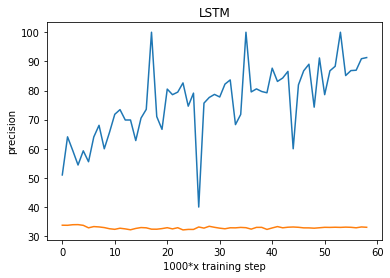

precision of the model on thevalidationdata: 33.015872955322266%
tensor([0.9233, 0.7633, 0.9319, 0.8900, 0.8356, 1.0000, 0.9193, 0.9238, 0.9916,
        0.7896, 0.9978, 0.5362, 0.8391, 1.0000, 0.9932, 0.5998, 0.9845, 0.6969,
        0.8442, 1.0000, 1.0000, 0.9544, 0.9653, 0.9994, 0.7246, 0.9999, 1.0000,
        0.9996, 0.9998, 0.5111, 1.0000, 1.0000, 1.0000, 0.5002, 0.9998, 0.9695,
        1.0000, 1.0000, 0.9970, 0.7806, 0.9982, 1.0000, 0.9999, 0.9941, 0.9832,
        0.9901, 1.0000, 0.9997, 0.9290, 0.9965, 0.9997, 0.5524, 0.9988, 0.9979,
        0.7686, 0.9909, 0.9999, 1.0000, 0.5708, 0.5480, 0.9994, 0.9999, 0.8939,
        1.0000, 0.9987, 0.9620, 1.0000, 1.0000, 0.9236, 0.9989, 0.9155, 0.5118,
        0.5186, 0.9997, 0.9996, 0.6385, 1.0000, 1.0000, 1.0000, 1.0000, 0.9753,
        0.9861, 0.9154, 0.8981, 0.8304, 0.9948, 0.9486, 0.5416, 0.5064, 0.7157,
        1.0000, 1.0000, 1.0000, 0.7781, 1.0000, 1.0000, 0.9996, 0.9998, 1.0000,
        0.9993], device='cuda:1')
current i is 10
Filte

precision of the model on thetrainingdata: 90.19607543945312%
precision of the model on thevalidationdata: 57.04854202270508%
precision of the model on thetrainingdata: 87.93103790283203%
precision of the model on thevalidationdata: 56.99107360839844%


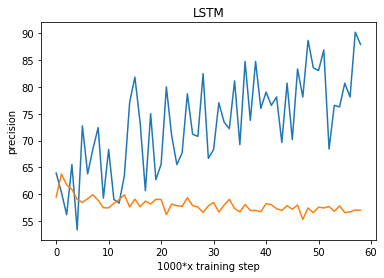

precision of the model on thevalidationdata: 57.14876174926758%
tensor([0.8474, 0.6699, 0.8189, 0.9670, 0.9606, 0.5322, 0.8457, 0.6227, 0.6572,
        0.6570, 0.6445, 0.6247, 0.9715, 0.6517, 0.9112, 0.5175, 0.5855, 0.7041,
        0.6738, 0.6997, 0.9405, 0.6685, 0.9196, 0.5338, 0.6789, 0.6862, 0.8643,
        0.5961, 0.6529, 0.7590, 0.8093, 0.5461, 0.8567, 0.5182, 0.7283, 0.6859,
        0.5346, 0.6881, 0.8109, 0.6557, 0.8552, 0.6459, 0.7458, 0.5898, 0.7517,
        0.7216, 0.6759, 0.8483, 0.6554, 0.6477, 0.6069, 0.5958, 0.7224, 0.8110,
        0.8529, 0.8899, 0.6958, 0.9204, 0.5903, 0.6233, 0.9782, 0.5974, 0.5357,
        0.5604, 0.6193, 0.7182, 0.8755, 0.6619, 0.5012, 0.5800, 0.6927, 0.8129,
        0.8967, 0.6927, 0.6563, 0.6823, 0.7557, 0.7270, 0.6829, 0.6891, 0.9038,
        0.7482, 0.6838, 0.6672, 0.7842, 0.5012, 0.9302, 0.7890, 0.6167, 0.6360,
        0.6603, 0.6549, 0.7037, 0.7923, 0.8676, 0.9219, 0.5005, 0.5751, 0.9427,
        0.5654], device='cuda:1')
current i is 11
Filter

precision of the model on thetrainingdata: 66.19718170166016%
precision of the model on thevalidationdata: 56.83604049682617%
precision of the model on thetrainingdata: 60.71428680419922%
precision of the model on thevalidationdata: 56.764495849609375%


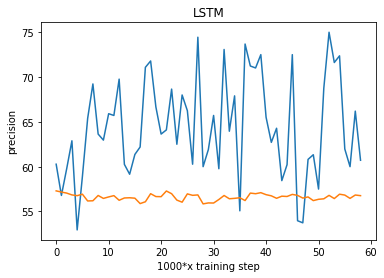

precision of the model on thevalidationdata: 56.07169723510742%
tensor([1.0000, 0.9471, 0.9997, 0.9992, 1.0000, 0.9999, 0.5324, 0.8601, 0.7519,
        0.9987, 0.8906, 0.9629, 0.9916, 1.0000, 1.0000, 0.8566, 0.9993, 0.5898,
        0.9787, 0.9767, 0.7150, 0.6696, 0.5803, 0.7091, 0.5823, 0.6533, 0.9893,
        0.9757, 0.9219, 1.0000, 0.5373, 1.0000, 1.0000, 0.5488, 0.8663, 0.9996,
        0.7856, 0.9256, 0.6983, 0.7857, 0.6625, 0.6331, 0.5120, 0.6556, 0.7762,
        0.5708, 0.7735, 0.7028, 0.9363, 1.0000, 1.0000, 0.8547, 0.7775, 0.5420,
        0.9648, 1.0000, 1.0000, 0.8041, 0.5174, 0.7590, 0.6967, 0.8269, 0.9074,
        0.8385, 0.9590, 0.9689, 0.6661, 0.7492, 0.7763, 0.5549, 0.6453, 0.6683,
        0.6276, 0.5935, 0.6911, 0.9980, 0.9999, 0.9999, 0.9750, 1.0000, 1.0000,
        0.9950, 0.7143, 1.0000, 0.6925, 0.8263, 0.5710, 0.6422, 0.5020, 0.6308,
        0.9312, 0.9387, 0.9921, 0.5355, 0.9611, 0.8246, 0.9830, 0.9999, 0.8191,
        0.5072], device='cuda:1')
current i is 12
Filter

precision of the model on thevalidationdata: 54.986019134521484%
precision of the model on thetrainingdata: 89.1891860961914%
precision of the model on thevalidationdata: 54.82857131958008%
precision of the model on thetrainingdata: 81.33333587646484%
precision of the model on thevalidationdata: 54.72824478149414%


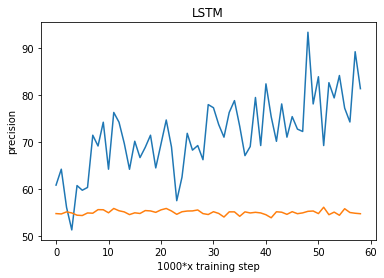

precision of the model on thevalidationdata: 55.307952880859375%
tensor([0.5868, 0.7268, 0.8637, 0.8331, 0.9938, 0.9044, 0.7902, 0.7509, 0.9386,
        0.9459, 0.5283, 0.6538, 0.8706, 0.5402, 0.8097, 0.5733, 0.9801, 0.9804,
        0.5518, 0.5262, 0.9700, 0.5657, 0.7332, 0.9065, 1.0000, 1.0000, 1.0000,
        0.9999, 0.9994, 1.0000, 0.5745, 0.6638, 0.7212, 0.6959, 0.8908, 0.6737,
        0.9060, 0.5905, 0.5405, 0.8898, 0.7825, 0.7653, 0.5231, 0.6695, 0.5244,
        0.9984, 0.9994, 0.9762, 0.8197, 0.5660, 0.7029, 0.6278, 0.7193, 0.6821,
        0.8732, 0.6157, 0.6420, 1.0000, 0.7603, 0.9270, 0.6779, 0.8735, 0.9754,
        0.5597, 0.6288, 0.9543, 0.5495, 0.5467, 0.5696, 0.8600, 0.7460, 0.8123,
        0.8934, 0.7039, 0.6815, 0.9145, 0.8518, 0.8120, 0.8991, 0.9984, 0.9647,
        0.5039, 0.7632, 0.7208, 0.5843, 0.5828, 0.6752, 0.8798, 0.7318, 0.5029,
        0.5161, 0.5104, 0.7017, 0.9959, 0.8104, 0.6676, 0.8651, 0.9993, 0.9991,
        0.5917], device='cuda:1')
current i is 13
Filte

precision of the model on thevalidationdata: 63.02407455444336%
precision of the model on thetrainingdata: 84.93150329589844%
precision of the model on thevalidationdata: 62.848026275634766%
precision of the model on thetrainingdata: 73.13433074951172%
precision of the model on thevalidationdata: 63.72795867919922%
precision of the model on thetrainingdata: 78.08219146728516%
precision of the model on thevalidationdata: 62.850215911865234%


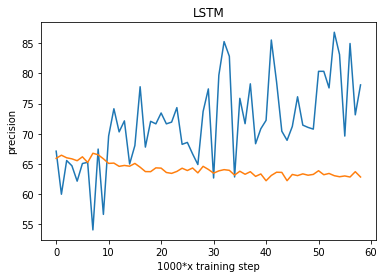

precision of the model on thevalidationdata: 62.761619567871094%
tensor([1.0000, 0.6014, 0.9102, 0.7164, 0.7325, 0.5244, 0.9560, 0.6775, 0.8450,
        0.9690, 0.7232, 0.9432, 0.8154, 0.8798, 0.7322, 0.9965, 0.9190, 0.8278,
        0.9730, 0.6550, 0.5182, 0.8865, 0.9517, 0.8495, 0.9928, 0.9999, 1.0000,
        0.7933, 0.9348, 0.8339, 1.0000, 0.9778, 0.9956, 0.9741, 0.9937, 0.6832,
        0.9044, 0.6654, 0.8475, 0.5268, 0.8645, 0.8934, 1.0000, 0.7751, 0.5436,
        0.8962, 0.6117, 0.7128, 0.9998, 0.9970, 0.9955, 1.0000, 0.9470, 0.5609,
        0.9579, 0.5381, 0.7159, 0.7511, 0.6930, 0.5658, 0.5819, 0.8658, 0.6440,
        0.5596, 0.6619, 0.5962, 0.7231, 0.7815, 0.6973, 0.8588, 0.5131, 0.5918,
        0.8214, 0.6848, 0.8009, 0.9979, 0.9827, 1.0000, 0.8364, 0.5951, 0.7515,
        1.0000, 0.8105, 0.8290, 0.8764, 0.9864, 0.8232, 0.6472, 0.8591, 0.5701,
        0.8348, 0.7438, 0.7193, 0.8120, 0.5467, 0.8951, 0.9867, 0.9994, 0.9997,
        1.0000], device='cuda:1')
current i is 15
Filte

precision of the model on thetrainingdata: 68.62744903564453%
precision of the model on thevalidationdata: 62.772926330566406%
precision of the model on thetrainingdata: 71.92982482910156%
precision of the model on thevalidationdata: 64.93236541748047%


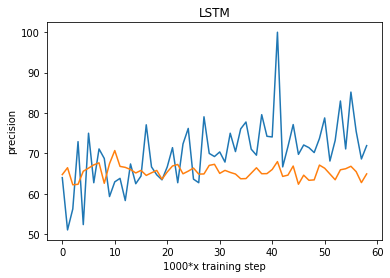

precision of the model on thevalidationdata: 66.53582000732422%
tensor([0.9322, 0.5468, 0.8741, 0.6565, 0.6598, 0.7831, 0.9464, 0.6354, 0.7944,
        0.5367, 0.5394, 0.7447, 0.5144, 0.5726, 0.5693, 0.9869, 0.6109, 0.5159,
        0.9461, 0.6362, 0.6222, 0.8156, 0.6575, 0.5953, 0.7439, 0.5228, 0.7470,
        0.6130, 0.9857, 0.6054, 0.5136, 0.9694, 0.9190, 0.9278, 0.6617, 0.6051,
        0.7588, 0.7297, 0.7794, 0.5990, 0.8304, 0.5564, 0.7429, 0.5886, 0.7850,
        0.7173, 0.7834, 0.7902, 0.7418, 0.9490, 0.8768, 0.5224, 0.6002, 0.5542,
        0.8365, 0.7062, 0.7540, 0.7583, 0.9967, 0.9996, 0.6045, 0.5235, 0.6015,
        0.5273, 0.6303, 0.7823, 0.5121, 0.6410, 0.7783, 0.7473, 0.8061, 0.5626,
        0.6473, 0.7195, 0.9236, 0.5798, 0.5978, 0.5965, 0.8214, 0.6398, 0.9938,
        0.9310, 0.7487, 0.8652, 0.6379, 0.6610, 0.7168, 0.5826, 0.5019, 0.7678,
        0.7507, 0.7053, 0.7012, 0.9071, 0.5739, 0.8525, 0.7201, 0.8067, 0.6275,
        0.5823], device='cuda:1')
current i is 16
Filter

precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 52.009456634521484%
precision of the model on thetrainingdata: 79.59183502197266%
precision of the model on thevalidationdata: 50.6618537902832%


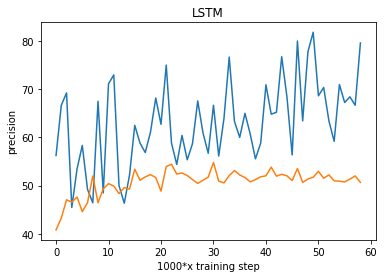

precision of the model on thevalidationdata: 51.555137634277344%
tensor([0.8974, 0.8489, 0.6890, 0.5689, 0.9995, 0.5722, 0.9788, 0.7894, 1.0000,
        0.7312, 0.6335, 1.0000, 0.7585, 0.6950, 0.8032, 1.0000, 0.8632, 0.5874,
        0.9807, 0.5822, 0.5845, 0.9021, 0.5088, 0.8544, 0.5929, 0.6652, 1.0000,
        0.6843, 0.6264, 0.9807, 0.6269, 0.8461, 0.6364, 0.6349, 0.9810, 0.6898,
        0.5066, 0.5202, 0.5935, 0.5387, 0.9591, 0.7078, 0.5050, 0.9992, 0.7241,
        0.6788, 0.8170, 0.6712, 0.7474, 0.9232, 0.8452, 0.5866, 0.7772, 0.5191,
        0.7839, 0.8527, 0.6993, 0.7460, 0.5005, 0.5859, 0.6593, 0.7881, 0.5439,
        1.0000, 0.7295, 0.7446, 0.9631, 0.6615, 0.9499, 0.9551, 0.6791, 0.6971,
        0.6244, 0.8006, 0.8917, 1.0000, 0.9996, 0.8887, 0.5067, 0.8875, 0.5264,
        0.5531, 0.7289, 0.6681, 0.6454, 0.5941, 0.9848, 1.0000, 0.5143, 0.6261,
        0.7175, 0.6044, 0.9230, 0.5231, 0.7536, 1.0000, 0.8492, 0.5152, 0.6466,
        0.5782], device='cuda:1')
current i is 17
Filte

precision of the model on thevalidationdata: 34.178401947021484%
precision of the model on thetrainingdata: 73.84615325927734%
precision of the model on thevalidationdata: 33.62289047241211%
precision of the model on thetrainingdata: 82.08955383300781%
precision of the model on thevalidationdata: 33.54838562011719%


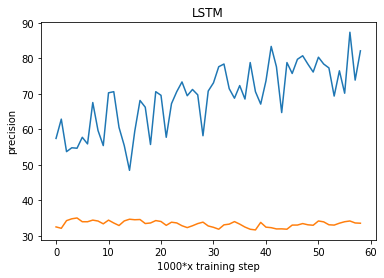

precision of the model on thevalidationdata: 33.71089553833008%
tensor([0.9913, 0.7486, 0.8069, 0.7301, 0.5549, 0.5501, 0.9890, 0.9387, 0.5954,
        0.5183, 1.0000, 0.8273, 0.5733, 0.6325, 0.6804, 0.5030, 0.6092, 0.9875,
        0.8566, 0.9868, 0.5196, 0.5098, 0.8731, 0.7788, 0.9586, 0.6638, 0.7644,
        0.7483, 0.8786, 0.5387, 0.5360, 0.7655, 0.9426, 0.9999, 1.0000, 0.9998,
        0.6347, 0.5650, 1.0000, 1.0000, 0.8167, 0.5699, 0.5130, 0.5151, 0.9633,
        0.5850, 0.9508, 0.9895, 0.5031, 0.6841, 0.8428, 0.9929, 0.6812, 0.7250,
        0.7171, 0.5070, 0.6760, 0.7040, 0.8405, 0.5535, 0.8588, 0.8341, 0.7773,
        0.8346, 0.9992, 0.5820, 0.7232, 0.6068, 0.9996, 0.9971, 0.9969, 0.9996,
        0.9999, 0.9731, 0.6489, 0.8501, 0.6435, 0.6324, 0.7889, 0.9213, 0.6082,
        0.5142, 0.8500, 0.7115, 0.6554, 0.9206, 0.5632, 1.0000, 0.7596, 0.5397,
        0.8001, 0.7270, 0.6806, 0.9958, 0.9923, 0.5768, 1.0000, 0.6214, 0.7027,
        0.7071], device='cuda:1')
current i is 18
Filter

precision of the model on thevalidationdata: 51.206302642822266%
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 50.238948822021484%
precision of the model on thetrainingdata: 76.78571319580078%
precision of the model on thevalidationdata: 50.83857345581055%


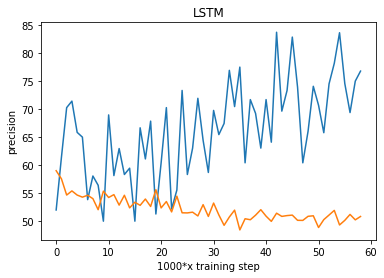

precision of the model on thevalidationdata: 49.10659408569336%
tensor([0.5228, 0.7008, 0.7259, 0.9477, 0.9756, 0.6899, 0.7072, 0.6275, 0.6766,
        0.7077, 0.6746, 0.7134, 0.7868, 0.6732, 0.5415, 0.7722, 0.5342, 0.5439,
        0.6631, 0.6757, 0.7322, 0.7243, 0.8344, 0.5778, 0.7411, 0.5311, 0.8291,
        0.6855, 0.6789, 0.7872, 0.7612, 0.6191, 0.7877, 0.7437, 0.8064, 0.7835,
        0.7095, 0.5872, 0.7929, 0.8074, 0.5815, 0.5590, 0.5394, 0.6804, 0.8231,
        0.5963, 0.7704, 0.5231, 0.8176, 0.8139, 0.7198, 0.8100, 0.7320, 0.6592,
        0.7461, 0.5672, 0.7403, 0.7098, 0.6951, 0.5838, 0.7287, 0.5301, 0.5562,
        0.7950, 0.7581, 0.5628, 0.6956, 0.7544, 0.6003, 0.5618, 0.6436, 0.5834,
        0.7338, 0.5926, 0.5306, 0.5417, 0.9004, 0.6581, 0.8225, 0.8633, 0.7288,
        0.6087, 0.7620, 0.6730, 0.7737, 0.5558, 0.7212, 0.5005, 0.5396, 0.7143,
        0.7702, 0.5318, 0.7426, 0.6684, 0.7870, 0.5009, 0.8935, 0.5504, 0.8441,
        0.5746], device='cuda:1')
current i is 19
Filter

precision of the model on thetrainingdata: 69.64286041259766%
precision of the model on thevalidationdata: 57.030277252197266%
precision of the model on thetrainingdata: 62.295082092285156%
precision of the model on thevalidationdata: 57.22140884399414%


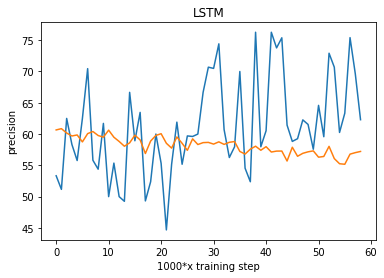

precision of the model on thevalidationdata: 57.34320068359375%
tensor([0.6691, 0.5557, 0.8097, 0.5700, 0.5815, 0.5652, 0.6060, 0.6853, 0.6709,
        0.6010, 0.5222, 0.6950, 0.5133, 0.5280, 0.6645, 0.6487, 0.5243, 0.5536,
        0.5883, 0.5753, 0.6701, 0.5846, 0.6215, 0.8056, 0.6412, 0.6627, 0.9812,
        0.5799, 0.5459, 0.5540, 0.6395, 0.5596, 0.5346, 0.6843, 0.6157, 0.5864,
        0.6518, 0.5155, 0.6580, 0.6258, 0.6227, 0.6453, 0.5573, 0.6636, 0.8263,
        0.5023, 0.7079, 0.5087, 0.5756, 0.5561, 0.5545, 0.5742, 0.6040, 0.6111,
        0.9451, 0.6082, 0.6098, 0.5947, 0.6308, 0.7907, 0.6191, 0.6019, 0.5429,
        0.6121, 0.5904, 0.5214, 0.6512, 0.6895, 0.6608, 0.6803, 0.5696, 0.5495,
        0.5041, 0.6903, 0.6587, 0.5108, 0.6648, 0.5289, 0.5776, 0.5226, 0.7257,
        0.6000, 0.5527, 0.7016, 0.5441, 0.6040, 0.6978, 0.6216, 0.5964, 0.5707,
        0.6264, 0.6081, 0.5433, 0.8754, 0.7050, 0.6624, 0.6456, 0.6964, 0.5903,
        0.6062], device='cuda:1')
current i is 20
Filter

precision of the model on thetrainingdata: 67.05882263183594%
precision of the model on thevalidationdata: 66.88134765625%
precision of the model on thetrainingdata: 71.73912811279297%
precision of the model on thevalidationdata: 66.802490234375%


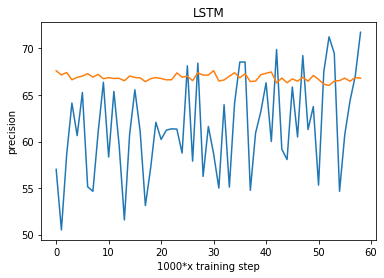

precision of the model on thevalidationdata: 66.483642578125%
tensor([0.5745, 0.8328, 0.9951, 0.9996, 0.9979, 0.8547, 0.6179, 0.7342, 0.8996,
        0.8307, 0.7157, 0.5671, 0.6121, 0.5617, 0.5962, 0.8331, 0.8005, 0.6441,
        0.6032, 0.5521, 0.5475, 0.8300, 0.5659, 0.8626, 0.5438, 0.6021, 0.6080,
        0.7024, 0.9585, 0.9813, 0.9111, 0.5474, 0.5739, 0.7614, 0.5188, 0.7225,
        0.5636, 0.6403, 0.5982, 0.6735, 0.7338, 0.7597, 0.6117, 0.9937, 0.5302,
        0.5032, 0.5840, 0.6088, 0.8445, 0.6453, 0.9769, 0.9406, 0.9745, 0.5855,
        0.5559, 0.5311, 0.7864, 0.6308, 0.6728, 0.5437, 0.6813, 0.9660, 0.6451,
        0.8420, 0.9698, 0.7430, 0.6453, 0.5056, 0.8330, 0.5742, 0.5107, 0.5123,
        0.7125, 0.6881, 0.5365, 0.6365, 0.7053, 0.9745, 0.9200, 0.9908, 1.0000,
        0.9651, 0.9470, 0.5254, 0.8000, 0.9530, 0.6673, 0.7365, 0.5666, 0.7073,
        0.5618, 0.8121, 0.8468, 0.8991, 0.5166, 0.6588, 0.5717, 0.6187, 0.8274,
        0.9365], device='cuda:1')
current i is 21
Filter l

precision of the model on thevalidationdata: 59.548255920410156%
precision of the model on thetrainingdata: 73.56321716308594%
precision of the model on thevalidationdata: 59.73185348510742%
precision of the model on thetrainingdata: 71.73912811279297%
precision of the model on thevalidationdata: 59.59431076049805%


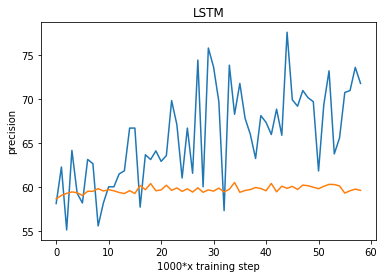

precision of the model on thevalidationdata: 59.657470703125%
tensor([0.6166, 0.9224, 1.0000, 0.5847, 0.7502, 0.6152, 0.6358, 0.5440, 0.6472,
        0.8602, 0.5589, 0.7305, 0.5661, 0.7157, 0.7268, 0.8951, 0.9185, 0.6275,
        0.8371, 0.5392, 0.6370, 0.7540, 0.5197, 0.6296, 0.6697, 0.7387, 0.5974,
        0.8164, 0.6196, 0.6989, 0.6610, 0.5104, 0.9202, 0.5955, 0.8344, 0.5600,
        0.6717, 0.9965, 0.7897, 1.0000, 0.8588, 0.9002, 0.5853, 0.5602, 0.7781,
        0.5299, 0.5840, 0.6773, 0.6646, 0.5266, 0.5019, 0.5041, 0.6696, 0.5687,
        0.6691, 0.6626, 0.7842, 0.7015, 0.5977, 0.5711, 0.5594, 0.5148, 0.6889,
        0.5421, 0.5525, 0.7436, 0.5352, 0.7230, 0.9298, 0.6079, 0.5195, 0.8448,
        0.7248, 0.6304, 0.9687, 0.7615, 0.8192, 0.5145, 0.8311, 0.5333, 0.5383,
        0.5470, 0.6130, 0.7706, 0.8129, 0.6311, 0.5432, 0.6638, 0.7938, 0.6208,
        0.7843, 0.7698, 0.6477, 0.5254, 0.5459, 0.9030, 0.6942, 0.5356, 0.6336,
        0.7548], device='cuda:1')
current i is 22
Filter l

precision of the model on thevalidationdata: 68.12998962402344%
precision of the model on thetrainingdata: 71.64179229736328%
precision of the model on thevalidationdata: 67.85124206542969%
precision of the model on thetrainingdata: 72.7272720336914%
precision of the model on thevalidationdata: 67.9767074584961%


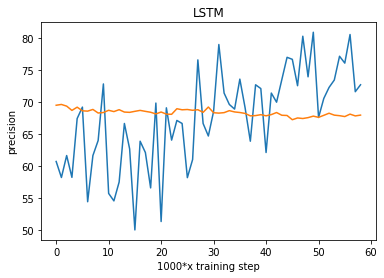

precision of the model on thevalidationdata: 68.34102630615234%
tensor([0.8168, 0.7670, 0.5707, 0.8967, 1.0000, 0.9982, 0.7526, 0.9993, 0.9285,
        0.5064, 0.7448, 0.9999, 1.0000, 1.0000, 0.9994, 0.7017, 0.8489, 0.9414,
        0.5467, 0.8392, 0.8791, 0.9268, 0.9224, 1.0000, 1.0000, 0.9750, 1.0000,
        0.9999, 1.0000, 0.9948, 1.0000, 0.8343, 0.9602, 0.6551, 1.0000, 0.9641,
        0.9995, 0.9974, 0.9659, 0.9998, 0.9988, 0.9998, 1.0000, 0.8503, 0.7770,
        0.9928, 0.7190, 0.5923, 0.6762, 0.9999, 0.9982, 1.0000, 0.9998, 0.9996,
        0.9744, 0.9996, 0.9166, 0.9999, 0.9991, 0.5073, 0.9972, 0.9988, 0.9971,
        0.9984, 0.9977, 0.9586, 0.8073, 0.8775, 1.0000, 0.9973, 0.9947, 0.5598,
        1.0000, 0.9545, 0.6022, 0.9313, 0.9349, 0.9942, 0.9594, 1.0000, 0.7158,
        0.9718, 0.9664, 0.5110, 0.8603, 0.5635, 0.7062, 0.7513, 1.0000, 1.0000,
        0.9623, 0.8491, 0.6177, 0.8889, 0.9992, 1.0000, 1.0000, 0.9928, 0.9990,
        1.0000], device='cuda:1')
current i is 23
Filter

precision of the model on thetrainingdata: 70.73170471191406%
precision of the model on thevalidationdata: 41.00046920776367%
precision of the model on thetrainingdata: 80.39215850830078%
precision of the model on thevalidationdata: 40.4683837890625%


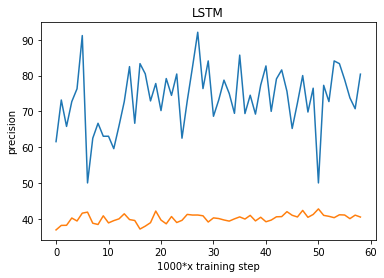

precision of the model on thevalidationdata: 42.44667053222656%
tensor([0.9996, 0.9501, 0.7039, 0.7861, 0.8981, 0.5656, 0.7549, 0.5024, 0.5077,
        0.8604, 0.9996, 0.5732, 0.8868, 0.9627, 0.7356, 0.5341, 0.9867, 0.7971,
        0.9039, 0.8861, 0.8343, 0.6983, 0.9996, 0.7601, 0.8183, 0.9143, 0.6824,
        0.8320, 0.6425, 0.7811, 0.7579, 0.5168, 0.7582, 0.8847, 0.7437, 0.5200,
        0.5276, 0.5453, 0.9195, 0.7293, 0.6248, 0.5586, 0.7909, 0.6347, 0.8104,
        0.7484, 0.9899, 0.6876, 0.7913, 0.9719, 0.7001, 0.5575, 0.7136, 0.6666,
        0.9356, 0.9926, 0.5004, 0.6623, 0.6367, 0.5037, 0.7260, 0.9282, 0.6484,
        0.5857, 0.5345, 0.6698, 0.6440, 0.6131, 0.5297, 0.8648, 0.7643, 0.5069,
        0.5065, 0.7317, 0.6111, 0.9801, 0.9871, 0.9242, 0.9999, 0.5194, 0.8279,
        0.6825, 0.6050, 0.5858, 0.8023, 0.7180, 0.6815, 0.5761, 0.7535, 0.6842,
        0.8273, 0.9929, 0.7004, 0.7915, 0.7736, 0.6869, 0.6889, 0.7939, 0.5417,
        0.5099], device='cuda:1')
current i is 24
Filter

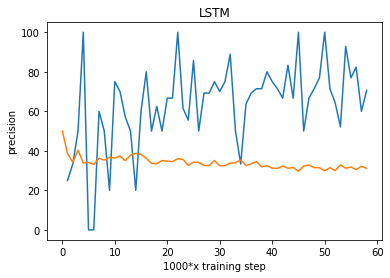

precision of the model on thevalidationdata: 31.533939361572266%
tensor([0.8153, 0.6295, 0.7621, 0.6985, 0.6709, 0.7133, 1.0000, 0.9929, 1.0000,
        0.7784, 0.6590, 0.8573, 0.6545, 0.5995, 0.9774, 0.5006, 0.8858, 0.6828,
        0.6495, 0.5716, 0.5559, 0.5690, 0.5899, 0.7075, 0.7021, 0.6985, 0.7921,
        0.6704, 0.7832, 0.5298, 0.7065, 0.8316, 0.8199, 0.6453, 0.5833, 0.8382,
        0.7765, 0.6544, 0.5372, 0.9540, 0.6072, 0.7631, 0.8174, 0.7158, 0.8483,
        0.9263, 0.9998, 0.7261, 0.7794, 0.6392, 0.8098, 0.7493, 0.7238, 0.8501,
        0.7792, 0.8827, 0.9389, 0.9958, 0.5066, 0.6931, 0.7305, 0.7753, 0.7442,
        0.7813, 0.5366, 0.8967, 0.9349, 0.6715, 0.6373, 0.5424, 0.8223, 0.6304,
        0.6751, 0.8914, 0.6224, 0.5685, 0.6336, 0.8565, 0.9998, 0.6590, 0.6521,
        0.7056, 0.7215, 0.7188, 0.9510, 0.7050, 0.5493, 0.7200, 0.7854, 0.5751,
        0.6973, 0.7623, 0.7796, 0.6191, 0.7070, 0.6240, 0.7723, 0.7851, 0.7155,
        0.6384], device='cuda:1')
current i is 25
Filte

precision of the model on thevalidationdata: 63.83430862426758%
precision of the model on thetrainingdata: 89.36170196533203%
precision of the model on thevalidationdata: 66.2432861328125%


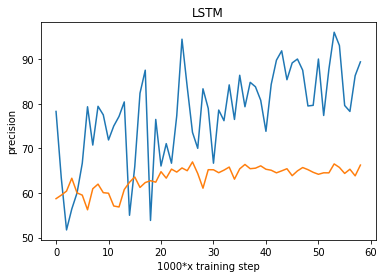

precision of the model on thevalidationdata: 64.85426330566406%
tensor([0.9998, 0.9065, 1.0000, 0.5309, 0.7351, 0.9282, 0.9586, 0.5868, 0.9989,
        1.0000, 0.9987, 0.7237, 0.9378, 0.9488, 0.9940, 0.9972, 0.8488, 0.9985,
        0.9819, 0.5933, 1.0000, 1.0000, 0.9916, 0.9978, 0.9394, 1.0000, 1.0000,
        0.6762, 0.5321, 0.9937, 0.9008, 0.8039, 0.9755, 0.9424, 0.6258, 0.9998,
        0.9778, 0.9485, 0.5394, 0.7055, 0.7129, 0.9356, 0.8808, 1.0000, 0.7594,
        0.9893, 0.6505, 0.7726, 0.6026, 0.9855, 0.5832, 0.9938, 0.9805, 0.9851,
        0.9444, 0.9843, 0.5242, 0.7078, 1.0000, 0.9842, 0.8181, 0.7970, 0.8968,
        0.6109, 0.9772, 0.9978, 0.5692, 0.9738, 0.9988, 0.7998, 0.9992, 0.5124,
        0.9566, 0.8761, 0.7804, 0.5256, 0.9972, 0.6105, 0.9920, 0.9999, 0.7499,
        1.0000, 0.8954, 0.8713, 0.7066, 0.9786, 0.6154, 0.9012, 1.0000, 0.7569,
        0.9552, 0.8508, 0.9231, 0.9815, 0.9957, 0.9356, 0.9577, 0.5874, 0.8276,
        0.9765], device='cuda:1')
current i is 26
Filter

precision of the model on thevalidationdata: 63.879600524902344%
precision of the model on thetrainingdata: 81.0810775756836%
precision of the model on thevalidationdata: 64.2922592163086%
precision of the model on thetrainingdata: 75.30863952636719%
precision of the model on thevalidationdata: 64.06609344482422%


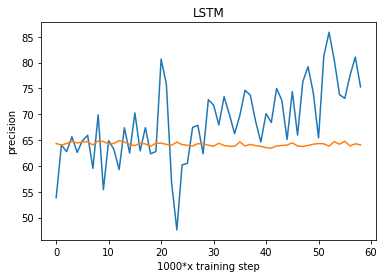

precision of the model on thevalidationdata: 63.71625900268555%
tensor([0.7212, 0.9838, 0.8084, 1.0000, 0.7482, 0.7376, 0.5976, 0.6063, 0.5427,
        0.9998, 1.0000, 0.5185, 0.9577, 0.6784, 0.7729, 0.5272, 0.7879, 0.6566,
        0.9975, 0.9701, 0.8325, 1.0000, 1.0000, 0.7775, 0.6589, 0.9818, 0.6529,
        0.7835, 0.9619, 0.8590, 0.5386, 0.6922, 0.5995, 1.0000, 0.9385, 0.8734,
        0.6735, 0.6964, 0.6985, 0.6094, 0.7511, 0.6688, 0.5236, 0.7440, 0.9633,
        0.9402, 0.6499, 0.8353, 0.6690, 0.8653, 0.6212, 1.0000, 0.9867, 0.5666,
        0.6658, 0.5344, 0.6556, 0.6116, 0.9721, 0.7729, 0.9999, 0.9963, 0.6607,
        0.7206, 0.5509, 0.6052, 0.9979, 0.9999, 0.6132, 0.9997, 1.0000, 0.9648,
        0.6535, 0.7819, 0.8974, 0.9997, 0.8272, 0.5604, 0.8670, 0.6579, 0.5868,
        0.7139, 1.0000, 0.7931, 0.9762, 0.9999, 0.8522, 0.5307, 0.7855, 0.8108,
        0.9897, 0.7402, 0.5806, 0.5441, 0.5176, 0.5139, 0.9073, 0.9799, 0.6484,
        0.8223], device='cuda:1')
current i is 27
Filter

precision of the model on thevalidationdata: 67.56128692626953%
precision of the model on thetrainingdata: 84.81012725830078%
precision of the model on thevalidationdata: 67.38138580322266%
precision of the model on thetrainingdata: 76.81159210205078%
precision of the model on thevalidationdata: 67.81395721435547%


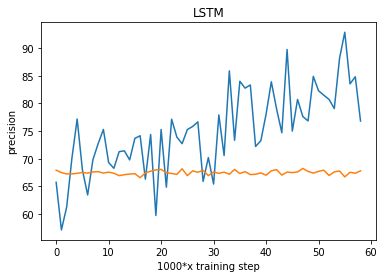

precision of the model on thevalidationdata: 67.87434387207031%
tensor([0.6576, 0.5106, 0.7821, 0.9999, 0.9951, 0.9677, 0.9062, 0.8617, 0.8019,
        0.6600, 0.9837, 0.5289, 0.8020, 0.6342, 0.9936, 0.6617, 0.9035, 0.5372,
        0.9623, 0.9006, 0.6942, 0.7423, 0.8739, 0.8705, 0.9766, 0.6912, 0.9127,
        0.8084, 0.7805, 0.9217, 0.7623, 0.9946, 0.9999, 0.8947, 0.7759, 0.7178,
        0.5964, 0.6294, 0.7484, 0.5807, 0.9121, 0.9999, 0.9043, 0.6279, 0.5195,
        0.5527, 0.8190, 0.9347, 0.6847, 0.9905, 0.5590, 0.5788, 0.5288, 0.9998,
        0.9908, 0.9882, 0.8796, 0.9358, 0.7579, 0.8323, 0.5920, 0.8887, 0.5945,
        0.6377, 0.8084, 0.8954, 0.7300, 0.9769, 0.5393, 0.8839, 1.0000, 0.9887,
        0.9805, 0.9905, 0.9994, 0.7524, 0.5934, 0.9956, 0.9128, 0.6465, 0.8182,
        0.9055, 0.6242, 0.9344, 0.8004, 0.5086, 0.8091, 0.6499, 0.7278, 0.9233,
        0.5008, 0.5777, 0.6454, 0.6758, 0.7122, 0.5109, 0.9564, 0.8546, 0.5548,
        0.9475], device='cuda:1')
current i is 28
Filter

precision of the model on thetrainingdata: 64.13043212890625%
precision of the model on thevalidationdata: 55.87349319458008%
precision of the model on thetrainingdata: 61.904762268066406%
precision of the model on thevalidationdata: 54.63517761230469%


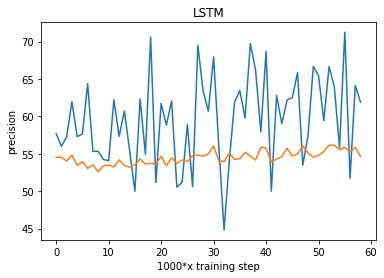

precision of the model on thevalidationdata: 55.8094482421875%
tensor([0.5923, 0.5239, 0.5569, 0.5387, 0.7621, 0.8829, 0.5009, 0.5207, 0.7083,
        0.5839, 0.6140, 0.6602, 0.6307, 0.5221, 0.5936, 0.5054, 0.5227, 0.5364,
        0.6523, 0.6129, 0.6978, 0.5900, 0.6150, 0.6429, 0.9891, 0.6008, 0.6042,
        0.5681, 0.5186, 0.5291, 0.6966, 0.7719, 0.5808, 0.6482, 0.5130, 0.5125,
        0.5226, 0.5359, 0.9991, 0.5022, 0.5162, 0.5999, 0.5811, 0.5506, 0.8517,
        0.7820, 0.5240, 0.5763, 0.6267, 0.5053, 0.5480, 0.6210, 0.6195, 0.5283,
        0.5587, 0.5937, 0.5250, 0.6562, 0.5851, 0.5260, 0.6932, 0.6256, 0.6852,
        0.6602, 0.9990, 0.9994, 1.0000, 0.7531, 0.5880, 0.5137, 0.5084, 0.5726,
        1.0000, 0.8757, 0.5305, 0.7354, 0.5172, 0.5687, 0.5791, 0.6285, 0.6088,
        0.5172, 0.9533, 0.9993, 0.5626, 0.5636, 0.6808, 0.5244, 0.6206, 0.5197,
        0.6004, 0.6340, 0.5083, 0.9508, 0.7136, 0.8025, 0.5779, 0.5855, 0.5845,
        0.6227], device='cuda:1')
current i is 29
Filter 

precision of the model on thetrainingdata: 71.0526351928711%
precision of the model on thevalidationdata: 56.12495422363281%
precision of the model on thetrainingdata: 69.76744079589844%
precision of the model on thevalidationdata: 55.912353515625%


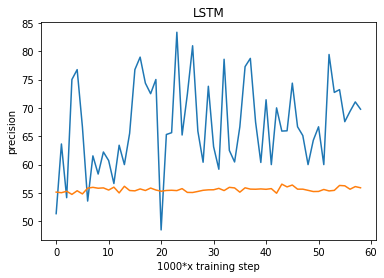

precision of the model on thevalidationdata: 57.04828643798828%
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.7945, 0.5472, 1.0000, 0.7185, 0.9929,
        0.6184, 0.9627, 0.9279, 1.0000, 0.8911, 0.9767, 0.9997, 0.5320, 0.8582,
        1.0000, 0.7738, 0.7713, 0.5056, 0.9653, 0.5617, 0.9808, 0.5960, 0.6393,
        0.5414, 0.8042, 0.5288, 1.0000, 0.9999, 0.5181, 0.7044, 0.6251, 1.0000,
        1.0000, 0.9999, 1.0000, 0.7690, 0.9548, 0.9998, 1.0000, 1.0000, 0.9988,
        0.6306, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5225, 0.9984, 1.0000, 1.0000, 1.0000, 0.8575, 0.5119, 0.9905,
        1.0000, 1.0000, 0.9970, 0.8778, 0.9999, 0.5113, 0.6240, 1.0000, 0.9994,
        1.0000, 0.9837, 1.0000, 0.9208, 0.9760, 1.0000, 0.6473, 0.7913, 1.0000,
        0.7777, 1.0000, 1.0000, 1.0000, 0.6005, 1.0000, 1.0000, 0.9942, 0.6854,
        1.0000, 1.0000, 0.8839, 0.7023, 1.0000, 1.0000, 0.6972, 0.6118, 0.6453,
        0.6560], device='cuda:1')
current i is 30
Filter

precision of the model on thevalidationdata: 42.820804595947266%
precision of the model on thetrainingdata: 68.67469787597656%
precision of the model on thevalidationdata: 42.52539825439453%
precision of the model on thetrainingdata: 70.12986755371094%
precision of the model on thevalidationdata: 43.25054168701172%


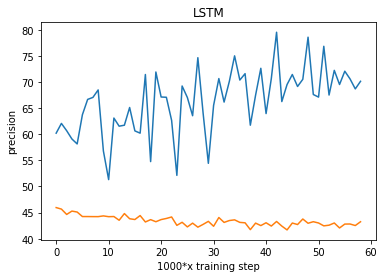

precision of the model on thevalidationdata: 43.120906829833984%
tensor([0.7390, 0.7145, 0.5567, 0.6623, 0.5683, 0.6663, 0.5255, 0.6333, 0.7706,
        0.8721, 0.9553, 0.7102, 0.6040, 0.6132, 0.8288, 0.6814, 0.9993, 0.5131,
        0.9796, 0.9239, 0.6218, 0.7471, 0.6311, 0.6180, 0.6900, 1.0000, 0.7529,
        0.6201, 0.8817, 0.5282, 0.5098, 0.7068, 0.6844, 0.9696, 0.7359, 0.8185,
        0.6557, 0.5437, 0.5298, 0.5156, 0.7602, 0.7866, 0.5169, 0.5928, 0.7346,
        0.6512, 0.7101, 0.6027, 0.5138, 0.6413, 0.5434, 0.7964, 0.5464, 0.7275,
        0.5951, 0.6093, 0.8559, 0.5218, 0.6899, 0.6285, 0.6221, 0.6327, 0.6516,
        0.7914, 0.6580, 0.6371, 0.5161, 0.7312, 0.5925, 0.5030, 0.5295, 0.6048,
        0.5190, 0.8813, 0.6690, 0.5943, 0.9112, 0.6448, 0.8547, 0.9827, 0.7296,
        0.8008, 0.5345, 0.5821, 0.8657, 0.6099, 0.7882, 0.6781, 0.5457, 0.5037,
        0.5995, 0.9357, 0.5255, 0.7735, 0.7040, 0.6228, 0.5296, 0.7306, 0.5689,
        0.5444], device='cuda:1')
current i is 31
Filte

precision of the model on thetrainingdata: 73.01587677001953%
precision of the model on thevalidationdata: 13.878469467163086%
precision of the model on thetrainingdata: 77.41935729980469%
precision of the model on thevalidationdata: 13.958192825317383%


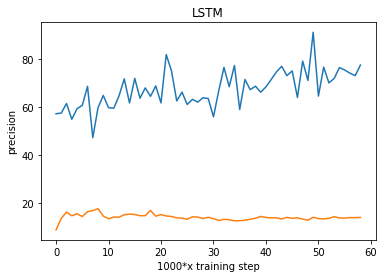

precision of the model on thevalidationdata: 12.747102737426758%
tensor([0.9997, 1.0000, 0.8474, 0.5855, 0.7386, 0.9999, 1.0000, 0.9920, 0.8816,
        0.9738, 0.6968, 0.7183, 1.0000, 0.5649, 0.9480, 1.0000, 0.9681, 0.9996,
        1.0000, 0.6712, 0.5869, 0.9999, 0.9966, 0.7527, 1.0000, 0.9999, 0.9948,
        1.0000, 0.9898, 0.9997, 0.8966, 1.0000, 0.9998, 0.9999, 0.7141, 0.9999,
        0.9372, 0.9976, 1.0000, 0.9998, 0.9542, 0.9918, 0.7120, 0.9998, 0.8907,
        0.9807, 0.9931, 0.9725, 0.9752, 1.0000, 0.9999, 0.5501, 0.9931, 1.0000,
        0.9992, 0.8451, 0.9868, 1.0000, 1.0000, 0.9279, 1.0000, 0.9123, 0.9976,
        0.9818, 0.9728, 0.9042, 0.7139, 0.9688, 1.0000, 0.8119, 0.8899, 1.0000,
        1.0000, 0.9573, 0.9731, 0.9434, 0.9951, 0.9999, 1.0000, 1.0000, 0.9931,
        0.9999, 1.0000, 0.9970, 1.0000, 0.9977, 0.8833, 0.7617, 1.0000, 0.9977,
        1.0000, 0.5877, 0.6599, 0.9955, 1.0000, 1.0000, 1.0000, 1.0000, 0.9758,
        0.9920], device='cuda:1')
current i is 32
Filte

precision of the model on thevalidationdata: 46.66299057006836%
precision of the model on thetrainingdata: 95.08197021484375%
precision of the model on thevalidationdata: 46.886844635009766%
precision of the model on thetrainingdata: 96.2264175415039%
precision of the model on thevalidationdata: 48.9361686706543%


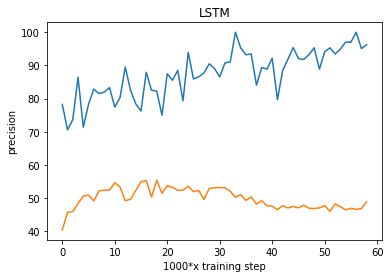

precision of the model on thevalidationdata: 46.05855941772461%
tensor([1.0000, 1.0000, 1.0000, 0.8444, 0.8224, 1.0000, 0.9998, 0.9998, 0.9938,
        0.9949, 1.0000, 1.0000, 0.9902, 1.0000, 0.9993, 0.9872, 0.9926, 0.9673,
        0.9870, 0.9318, 1.0000, 0.9978, 0.9997, 0.5412, 0.9829, 0.6257, 0.9221,
        1.0000, 0.9975, 1.0000, 0.9999, 0.6534, 0.9888, 0.6107, 1.0000, 0.9533,
        0.8926, 1.0000, 0.5523, 0.8209, 0.9969, 0.9999, 0.9846, 0.9999, 0.9977,
        0.9988, 0.5860, 0.6459, 0.6279, 0.9981, 0.9975, 0.9978, 0.9468, 0.9943,
        0.5505, 0.9995, 0.9984, 0.8147, 0.8830, 0.9816, 0.8496, 0.9907, 0.9953,
        1.0000, 0.9611, 1.0000, 0.6235, 0.6488, 0.5104, 0.8517, 0.9962, 0.9998,
        0.9922, 0.8388, 0.9944, 0.9999, 1.0000, 0.9981, 1.0000, 1.0000, 0.9360,
        1.0000, 0.9971, 0.9863, 1.0000, 1.0000, 0.9807, 0.6002, 0.5698, 0.5406,
        0.9238, 0.9992, 1.0000, 0.9991, 1.0000, 0.8693, 0.9991, 0.9996, 0.9877,
        0.9944], device='cuda:1')
current i is 33
Filter

precision of the model on thevalidationdata: 37.434749603271484%
precision of the model on thetrainingdata: 90.5882339477539%
precision of the model on thevalidationdata: 37.872840881347656%
precision of the model on thetrainingdata: 82.27848052978516%
precision of the model on thevalidationdata: 38.30715560913086%


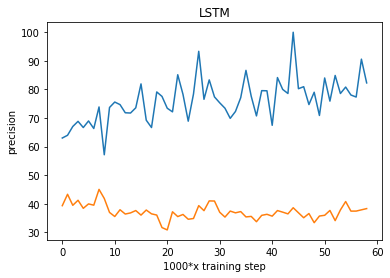

precision of the model on thevalidationdata: 35.14107894897461%
tensor([0.9908, 0.7949, 0.6495, 0.9379, 0.9999, 0.9952, 0.7267, 0.5507, 0.8421,
        0.9990, 0.9998, 0.7902, 0.7048, 1.0000, 0.8306, 0.5294, 0.8946, 0.6069,
        1.0000, 0.9593, 0.5303, 0.9990, 0.6147, 0.9795, 0.9998, 0.9999, 0.8115,
        1.0000, 0.9637, 0.6423, 1.0000, 0.6471, 0.9211, 0.7691, 0.5129, 0.5953,
        0.7638, 0.6055, 0.8160, 0.6015, 0.5207, 0.7095, 0.9921, 0.9864, 0.9758,
        0.9933, 0.5777, 0.6930, 0.9897, 0.9995, 0.8362, 0.9399, 0.9857, 0.7536,
        0.8623, 0.9787, 0.5850, 1.0000, 0.8795, 0.5216, 0.7065, 0.7911, 0.6131,
        1.0000, 0.9900, 0.6171, 1.0000, 0.9998, 0.7381, 0.9966, 0.6373, 0.8909,
        0.9998, 0.9524, 0.5016, 0.9974, 0.9724, 0.6726, 0.9778, 0.9958, 0.8354,
        0.9836, 0.9451, 0.5040, 0.9475, 0.9093, 0.6289, 0.9933, 0.9326, 0.6892,
        1.0000, 0.6049, 0.6491, 0.8554, 0.6312, 0.5970, 0.9919, 1.0000, 0.7417,
        0.7708], device='cuda:1')
current i is 34
Filter

precision of the model on thevalidationdata: 56.56419372558594%
precision of the model on thetrainingdata: 91.37931060791016%
precision of the model on thevalidationdata: 56.19707489013672%
precision of the model on thetrainingdata: 98.61111450195312%
precision of the model on thevalidationdata: 55.23918151855469%


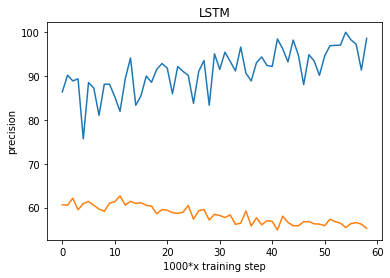

precision of the model on thevalidationdata: 55.730926513671875%
tensor([0.8903, 0.9116, 0.9987, 0.9993, 0.9081, 1.0000, 1.0000, 0.9923, 1.0000,
        0.9369, 0.9992, 0.9678, 0.5465, 0.9916, 0.9948, 0.9966, 0.7406, 0.9996,
        0.9866, 0.6802, 0.9936, 0.9987, 0.9974, 0.9985, 1.0000, 0.9850, 1.0000,
        0.9957, 0.7104, 0.9967, 0.9638, 0.5412, 0.9563, 0.8891, 0.5662, 1.0000,
        0.5338, 0.9924, 0.9981, 0.5354, 0.9983, 0.9999, 1.0000, 0.6401, 1.0000,
        0.9321, 1.0000, 0.6081, 0.8537, 0.9999, 1.0000, 0.9893, 0.9817, 0.8912,
        1.0000, 0.9974, 0.7843, 0.9990, 0.9861, 0.9813, 0.9991, 0.9996, 1.0000,
        1.0000, 0.9856, 0.9893, 0.8784, 0.6756, 0.9482, 0.9092, 0.9809, 0.9938,
        0.8762, 1.0000, 1.0000, 0.9734, 0.9925, 0.9997, 0.9991, 0.5008, 0.9630,
        0.9941, 0.9888, 0.8644, 0.5006, 0.9992, 0.9539, 1.0000, 1.0000, 0.9996,
        1.0000, 0.9999, 0.9857, 0.9995, 1.0000, 1.0000, 0.7077, 0.9361, 0.9989,
        0.9641], device='cuda:1')
current i is 35
Filte

precision of the model on thevalidationdata: 55.0875129699707%
precision of the model on thetrainingdata: 86.9565200805664%
precision of the model on thevalidationdata: 55.49972152709961%
precision of the model on thetrainingdata: 86.44068145751953%
precision of the model on thevalidationdata: 55.25271224975586%


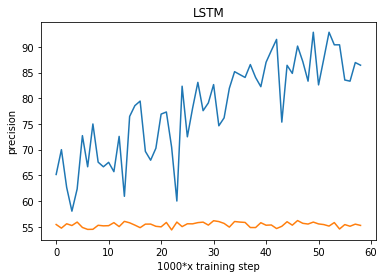

precision of the model on thevalidationdata: 55.37101364135742%
tensor([0.6210, 0.6671, 0.9650, 0.8996, 0.7051, 0.9797, 0.8948, 0.5870, 0.9457,
        0.9989, 0.6508, 0.9715, 0.9948, 0.9637, 0.7108, 0.6334, 0.9249, 0.9953,
        0.8139, 0.6756, 0.9978, 0.6827, 0.9999, 0.9932, 0.9427, 0.9984, 0.9945,
        0.8189, 0.9925, 0.8864, 0.7573, 0.6253, 0.9920, 0.7011, 1.0000, 0.5588,
        0.9456, 0.9952, 0.9906, 0.9354, 0.5914, 0.9831, 0.9037, 0.9804, 0.5479,
        0.6129, 0.5744, 0.9928, 0.9996, 0.7901, 0.9968, 0.8280, 0.9636, 0.8758,
        0.5208, 0.5114, 0.8507, 0.8930, 0.9262, 0.8727, 0.9514, 0.9605, 0.9873,
        0.9916, 0.9437, 0.9996, 0.8436, 0.9755, 0.9193, 0.9930, 0.8128, 0.6666,
        0.5144, 0.9261, 0.9992, 0.5700, 0.6518, 0.8330, 0.9935, 0.9998, 0.5455,
        0.6788, 0.9761, 0.5774, 0.8858, 0.6395, 0.9468, 0.9698, 0.8088, 0.9793,
        0.9872, 0.7143, 0.7279, 0.9567, 0.9332, 0.9799, 0.8818, 0.9233, 0.8491,
        0.7751], device='cuda:1')
current i is 36
Filter

precision of the model on thevalidationdata: 61.147457122802734%
precision of the model on thetrainingdata: 58.064517974853516%
precision of the model on thevalidationdata: 58.88463592529297%
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 58.83256530761719%


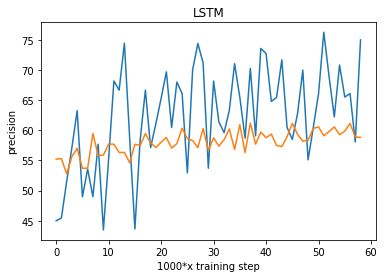

precision of the model on thevalidationdata: 60.42470932006836%
tensor([0.5690, 0.6069, 0.7164, 0.7127, 0.6548, 0.5062, 0.7084, 0.7180, 0.8092,
        0.8519, 0.7059, 0.6953, 0.7585, 0.5649, 0.7815, 0.9028, 0.5334, 0.5064,
        0.9328, 0.6336, 0.6660, 0.6233, 0.5566, 0.5861, 0.5788, 0.7635, 0.9943,
        0.5639, 0.7448, 0.9219, 0.7146, 0.8546, 0.9220, 0.9141, 0.9053, 0.6214,
        0.6520, 0.5425, 0.7929, 0.5832, 0.8485, 0.5458, 0.5042, 0.7195, 0.7562,
        0.9190, 0.6172, 0.5784, 0.5703, 0.9414, 0.6753, 0.6199, 0.7534, 0.5482,
        0.9925, 0.5329, 0.9447, 0.9220, 0.8826, 0.5664, 0.6870, 0.8467, 0.6153,
        0.5885, 0.6903, 0.5359, 0.5927, 0.5139, 0.6340, 0.6325, 0.6448, 0.5212,
        0.9587, 0.9939, 0.7300, 0.8755, 0.6430, 0.7041, 0.5177, 0.5837, 0.6138,
        0.8873, 0.6422, 0.8288, 0.6646, 0.5605, 0.7368, 0.6553, 0.9971, 0.9757,
        0.7025, 0.7304, 0.6049, 0.6913, 0.9721, 0.6415, 0.6268, 0.6863, 0.6968,
        0.8760], device='cuda:1')
current i is 37
Filter

precision of the model on thetrainingdata: 72.58064270019531%
precision of the model on thevalidationdata: 38.19023895263672%
precision of the model on thetrainingdata: 77.63157653808594%
precision of the model on thevalidationdata: 38.21467208862305%


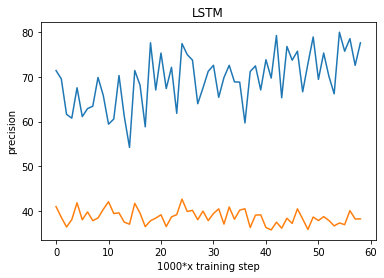

precision of the model on thevalidationdata: 38.8355712890625%
tensor([0.9998, 0.7354, 0.6979, 0.6557, 0.6800, 0.5382, 0.7720, 0.5748, 0.6441,
        1.0000, 0.5398, 0.6589, 0.9999, 0.5719, 0.5411, 0.9926, 0.5447, 0.5915,
        0.8293, 0.5925, 0.6270, 0.7070, 0.6146, 0.6176, 0.7571, 0.6011, 0.6107,
        0.6480, 0.7004, 0.5818, 0.9972, 0.6045, 0.7103, 0.9982, 0.5019, 0.8485,
        0.5187, 0.6496, 0.7757, 0.8423, 0.7530, 0.7216, 0.9235, 0.7561, 0.5180,
        0.5655, 0.5796, 0.5461, 0.8349, 0.6110, 0.5513, 0.6831, 0.6078, 0.5573,
        0.5066, 0.6029, 0.5724, 0.7608, 0.8671, 0.6435, 0.6051, 0.6786, 0.5756,
        0.8480, 0.6547, 0.5756, 0.8092, 0.5739, 0.7246, 0.8246, 0.6400, 0.5838,
        0.6225, 0.5961, 0.5565, 0.7113, 0.6520, 0.7306, 0.5767, 0.6123, 0.7831,
        0.9674, 0.7119, 0.8481, 0.8273, 0.5831, 0.5082, 0.6309, 0.6328, 0.5438,
        1.0000, 0.5751, 0.6282, 0.7451, 0.5228, 0.6066, 0.9997, 0.5711, 0.5100,
        0.6526], device='cuda:1')
current i is 38
Filter 

precision of the model on thevalidationdata: 52.06185531616211%
precision of the model on thetrainingdata: 86.66666412353516%
precision of the model on thevalidationdata: 52.255638122558594%


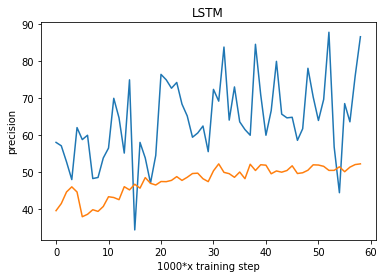

precision of the model on thevalidationdata: 53.24074172973633%
tensor([1.0000, 0.9999, 0.9599, 1.0000, 0.8904, 1.0000, 1.0000, 0.9994, 1.0000,
        1.0000, 1.0000, 0.8391, 1.0000, 0.6463, 0.6139, 0.9999, 0.9057, 0.9992,
        0.9998, 0.9999, 1.0000, 1.0000, 0.9997, 0.9896, 0.7250, 0.6051, 0.9987,
        1.0000, 0.6999, 1.0000, 1.0000, 0.7110, 1.0000, 1.0000, 0.9836, 0.8707,
        0.8608, 0.8806, 0.9963, 1.0000, 0.9909, 0.9188, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9937, 0.9984, 1.0000, 1.0000, 1.0000, 0.7662, 0.7231, 0.5521,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9574, 0.7657,
        0.9937, 0.5666, 1.0000, 1.0000, 0.9995, 1.0000, 0.7106, 0.9922, 1.0000,
        0.6405, 1.0000, 0.9596, 1.0000, 0.6872, 0.9998, 0.9983, 0.8637, 1.0000,
        1.0000, 1.0000, 0.9738, 0.6604, 1.0000, 1.0000, 1.0000, 0.9174, 0.9258,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9959, 1.0000,
        1.0000], device='cuda:1')
current i is 39
Filter

precision of the model on thetrainingdata: 62.85714340209961%
precision of the model on thevalidationdata: 41.65289306640625%
precision of the model on thetrainingdata: 61.290321350097656%
precision of the model on thevalidationdata: 43.69158935546875%
precision of the model on thetrainingdata: 74.19355010986328%
precision of the model on thevalidationdata: 44.435611724853516%


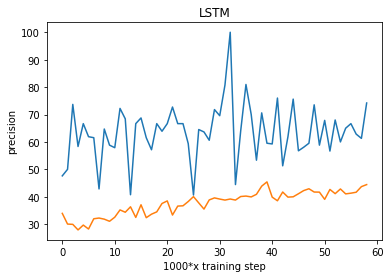

precision of the model on thevalidationdata: 41.52352523803711%
tensor([0.7684, 0.8356, 0.7802, 0.5504, 1.0000, 0.9849, 0.9702, 0.9997, 1.0000,
        0.6793, 0.8072, 0.6947, 0.7846, 0.7091, 0.7154, 0.5223, 0.9999, 0.9895,
        0.7103, 1.0000, 0.6167, 0.8540, 0.5990, 0.9861, 0.9885, 1.0000, 0.6021,
        0.7891, 0.9977, 1.0000, 0.8927, 0.7945, 0.5685, 0.9160, 0.9249, 1.0000,
        0.5444, 0.7908, 0.8356, 0.9561, 1.0000, 0.9946, 0.8866, 0.5765, 0.9626,
        0.7062, 0.9599, 1.0000, 0.7400, 0.7094, 0.7006, 0.8130, 1.0000, 0.9905,
        0.5492, 0.6505, 1.0000, 0.8270, 1.0000, 0.9999, 0.9986, 0.8119, 0.6053,
        0.9214, 0.5535, 0.9418, 0.8485, 0.7736, 0.6092, 0.7586, 0.9300, 1.0000,
        0.8341, 0.8258, 0.6157, 0.8647, 0.9524, 0.9981, 0.9888, 0.9993, 0.8838,
        0.8725, 0.8873, 0.6038, 0.5140, 0.9277, 0.7621, 1.0000, 0.9995, 0.9072,
        0.8698, 1.0000, 0.9468, 0.7302, 0.9986, 1.0000, 1.0000, 0.9923, 0.9506,
        0.8922], device='cuda:1')
current i is 41
Filter

precision of the model on thetrainingdata: 72.0%
precision of the model on thevalidationdata: 44.05982971191406%
precision of the model on thetrainingdata: 72.05882263183594%
precision of the model on thevalidationdata: 43.56435775756836%


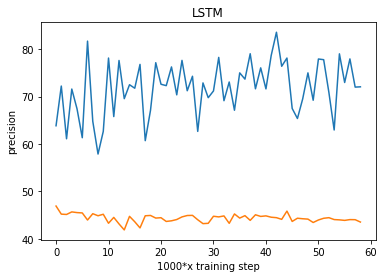

precision of the model on thevalidationdata: 44.639591217041016%
tensor([0.5531, 0.6156, 0.6599, 0.7400, 0.6298, 0.8191, 0.5107, 0.6835, 0.8776,
        0.5290, 0.8613, 0.9571, 0.6322, 0.9717, 0.6046, 0.6526, 0.6315, 0.5023,
        0.7127, 0.8343, 0.6935, 0.6652, 0.7993, 0.5828, 0.7752, 0.9969, 0.5018,
        0.6691, 0.6532, 0.9999, 0.7311, 0.5382, 0.5862, 0.8392, 0.6263, 0.7475,
        0.5183, 0.8805, 0.5584, 0.6706, 0.6204, 0.7052, 0.5232, 0.5330, 0.5908,
        0.6428, 0.5489, 0.6687, 0.5185, 0.9929, 0.6924, 0.5280, 0.5503, 0.9972,
        0.5839, 0.8587, 0.6014, 0.5429, 0.7308, 0.9171, 0.9887, 0.8006, 0.6975,
        0.6692, 0.5988, 0.5710, 0.5064, 0.5071, 0.5682, 0.5181, 0.7937, 0.5257,
        0.5046, 0.8434, 0.5722, 0.5657, 0.6336, 0.8137, 0.9404, 0.7177, 0.9984,
        0.7184, 0.5110, 0.5333, 0.9934, 0.8606, 0.8278, 0.6594, 0.5808, 0.6594,
        0.8117, 0.6755, 0.5382, 0.8924, 0.6194, 0.5234, 0.6281, 0.5963, 0.5376,
        0.6327], device='cuda:1')
current i is 42
Filte

precision of the model on thetrainingdata: 68.18181610107422%
precision of the model on thevalidationdata: 36.52326583862305%


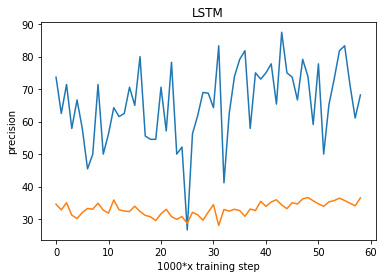

precision of the model on thevalidationdata: 36.02751541137695%
tensor([0.6812, 0.7415, 0.6812, 0.6979, 0.8015, 0.9921, 0.7514, 0.5652, 0.7741,
        0.7825, 0.6938, 0.6487, 0.7627, 0.8722, 0.5105, 0.7054, 0.5853, 0.6060,
        0.6526, 0.8025, 0.5864, 0.6631, 0.5949, 0.7130, 0.7114, 0.7521, 0.7180,
        0.5938, 0.6882, 0.7676, 0.9960, 0.9795, 0.6568, 0.7866, 0.7169, 0.6025,
        0.7072, 0.7044, 0.7393, 0.9797, 0.7851, 0.9250, 0.6189, 0.8587, 0.8101,
        0.6791, 0.6506, 0.9051, 0.5820, 0.7489, 0.6969, 0.5827, 0.9326, 0.6246,
        0.7275, 0.5618, 0.5501, 0.9427, 0.6041, 0.8568, 0.6392, 0.6498, 0.6713,
        0.8572, 0.6968, 0.7719, 0.5881, 0.6331, 0.6965, 0.6789, 0.7408, 0.6827,
        0.7062, 0.6370, 0.5504, 0.5722, 0.5405, 0.8453, 0.6131, 0.6803, 0.7242,
        0.6055, 0.7412, 0.9518, 0.6994, 0.7402, 0.6168, 0.9688, 0.9978, 0.7332,
        0.5391, 0.6545, 0.7766, 0.9145, 0.9083, 0.5720, 0.7017, 0.6210, 0.6992,
        0.6143], device='cuda:1')
current i is 43
Filter

precision of the model on thevalidationdata: 44.42606735229492%
precision of the model on thetrainingdata: 87.5%
precision of the model on thevalidationdata: 43.65513229370117%
precision of the model on thetrainingdata: 86.36363983154297%
precision of the model on thevalidationdata: 42.93590545654297%


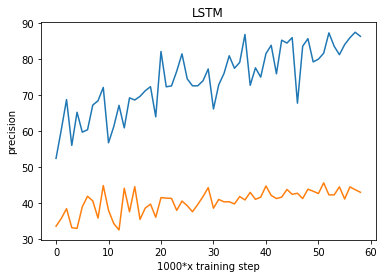

precision of the model on thevalidationdata: 45.25139617919922%
tensor([0.8743, 0.7921, 0.5299, 0.7548, 0.5489, 0.6697, 0.7529, 0.6070, 0.6102,
        0.6146, 0.9162, 0.8622, 0.5651, 0.5686, 0.8244, 0.8818, 0.7449, 0.6773,
        0.7267, 0.5879, 0.5136, 0.5086, 0.5335, 0.6597, 0.8684, 0.6589, 0.5379,
        0.5075, 0.8434, 0.5913, 0.6360, 0.6465, 0.6511, 0.6813, 0.6022, 0.6100,
        0.6156, 0.9429, 0.8319, 0.9205, 0.9191, 0.6911, 0.7737, 0.8349, 0.5922,
        0.7516, 0.9306, 0.6054, 0.5946, 0.9070, 0.9083, 0.8660, 0.5361, 0.8077,
        0.9785, 0.8049, 0.5661, 0.8963, 0.5886, 0.5178, 0.9715, 0.9496, 0.8980,
        0.5951, 0.9702, 0.7553, 0.7382, 0.6771, 0.6596, 0.7283, 0.6225, 0.8979,
        0.5613, 0.8524, 0.5713, 0.6142, 0.9338, 0.8529, 0.6809, 0.9125, 0.8581,
        0.5891, 0.9380, 0.8315, 0.5680, 0.5950, 0.5489, 0.7161, 0.7093, 0.5284,
        0.6096, 0.6029, 0.6870, 0.6138, 0.6372, 0.6759, 0.7667, 0.8844, 0.5969,
        0.5533], device='cuda:1')
current i is 44
Filter

precision of the model on thevalidationdata: 40.54319381713867%
precision of the model on thetrainingdata: 64.81481170654297%
precision of the model on thevalidationdata: 40.47191619873047%
precision of the model on thetrainingdata: 75.71428680419922%
precision of the model on thevalidationdata: 40.993038177490234%


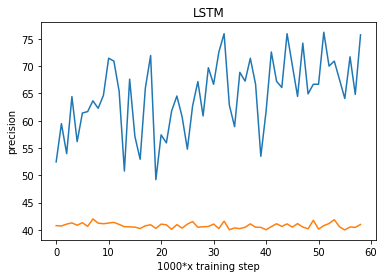

precision of the model on thevalidationdata: 41.16945266723633%
tensor([0.7899, 0.5237, 0.5189, 0.5768, 0.7363, 0.7445, 0.6509, 0.5484, 0.6459,
        0.6629, 0.8213, 0.5452, 0.7074, 0.6297, 0.8256, 0.6850, 0.6973, 0.6576,
        0.6580, 0.8287, 0.8398, 0.5469, 0.7048, 0.6334, 0.6627, 0.6454, 0.7118,
        0.6247, 0.5637, 0.6513, 0.7394, 0.5144, 0.5366, 0.5559, 0.6628, 0.5794,
        0.6983, 0.6566, 0.7951, 0.5536, 0.7333, 0.5107, 0.5534, 0.6081, 0.6001,
        0.8182, 0.7862, 1.0000, 0.5575, 0.8236, 0.5079, 0.6454, 0.5930, 0.6964,
        0.6994, 0.5612, 0.5693, 0.5121, 0.8651, 0.7099, 0.7392, 0.7742, 0.6068,
        0.7406, 0.6877, 0.5739, 0.6234, 0.5881, 0.5002, 0.5651, 0.5286, 0.7619,
        0.5878, 0.5437, 0.5993, 0.6562, 0.5559, 0.6154, 0.8139, 0.5825, 0.6494,
        0.6345, 0.6039, 0.5494, 0.5185, 0.5556, 0.5210, 0.5638, 0.5262, 0.5983,
        0.6669, 0.8518, 0.5972, 0.5054, 0.5994, 0.7733, 0.5394, 0.9719, 0.7190,
        0.9214], device='cuda:1')
current i is 45
Filter

precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 49.96903991699219%
precision of the model on thetrainingdata: 68.75%
precision of the model on thevalidationdata: 49.58279800415039%


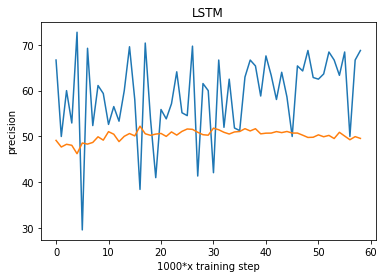

precision of the model on thevalidationdata: 50.333229064941406%
tensor([0.7500, 0.8353, 0.8497, 0.9990, 0.9998, 0.9992, 0.5340, 0.8429, 1.0000,
        0.6129, 0.8645, 0.9991, 1.0000, 0.9935, 1.0000, 0.7588, 0.9994, 0.9989,
        0.6051, 0.7290, 0.7245, 0.7886, 0.8661, 1.0000, 0.5584, 0.9686, 0.8778,
        0.5891, 0.6926, 0.5962, 0.9148, 1.0000, 0.9997, 0.6376, 0.9775, 0.8236,
        0.9969, 0.9999, 1.0000, 0.8762, 0.7121, 0.8864, 0.6804, 1.0000, 0.9998,
        0.7944, 0.9975, 0.9992, 0.7842, 0.7518, 0.5616, 0.6525, 0.9929, 0.9925,
        0.8922, 0.7832, 0.7579, 0.7735, 0.5746, 0.7491, 0.6924, 0.7405, 0.8121,
        0.5998, 0.5586, 0.5618, 0.5294, 0.7775, 0.9972, 0.6042, 0.9077, 0.9604,
        0.5175, 0.9518, 1.0000, 0.5710, 0.9969, 0.9955, 0.9999, 1.0000, 1.0000,
        0.9515, 0.5991, 0.6374, 0.6865, 0.6185, 0.5834, 0.6388, 1.0000, 0.8635,
        0.6468, 0.6396, 0.6830, 0.9255, 0.9997, 0.9972, 0.9999, 1.0000, 1.0000,
        0.7764], device='cuda:1')
current i is 46
Filte

precision of the model on thevalidationdata: 54.94629669189453%
precision of the model on thetrainingdata: 80.0%
precision of the model on thevalidationdata: 56.49100112915039%


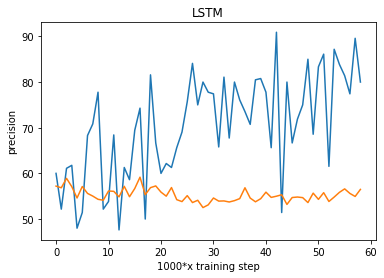

precision of the model on thevalidationdata: 56.171146392822266%
tensor([0.9664, 0.5397, 0.8690, 0.6331, 0.8838, 0.9381, 0.6390, 0.6961, 0.7433,
        0.5482, 0.5500, 0.6621, 0.5871, 0.5207, 0.5359, 0.9996, 0.9923, 0.9984,
        0.8582, 0.8230, 0.6317, 0.5557, 0.7682, 0.8615, 0.8869, 0.6907, 0.7731,
        0.7737, 0.6348, 0.6977, 0.8618, 0.8967, 0.7426, 0.8635, 0.8288, 0.8324,
        0.6936, 0.7695, 0.8342, 0.6091, 0.8268, 0.5584, 0.5002, 0.5880, 0.6053,
        0.8699, 0.6936, 0.5704, 0.7898, 0.8765, 0.9818, 0.5886, 0.5068, 0.8261,
        0.8450, 0.7222, 0.6184, 0.5769, 0.5875, 0.6821, 0.8811, 0.6220, 0.5289,
        0.8366, 0.6484, 0.8823, 0.6295, 0.6583, 0.7330, 0.5202, 0.6942, 0.6074,
        0.8776, 0.7976, 0.9425, 0.7920, 0.5550, 0.6064, 0.7720, 0.8886, 0.8686,
        0.5784, 0.6317, 0.5216, 0.6199, 0.7477, 0.9174, 0.5274, 0.5150, 0.8671,
        0.7698, 0.7703, 0.5804, 0.8521, 0.6202, 0.6643, 0.5271, 0.6390, 0.5313,
        0.7902], device='cuda:1')
current i is 47
Filte

precision of the model on thetrainingdata: 62.74509811401367%
precision of the model on thevalidationdata: 55.25210189819336%
precision of the model on thetrainingdata: 56.25%
precision of the model on thevalidationdata: 55.2532844543457%


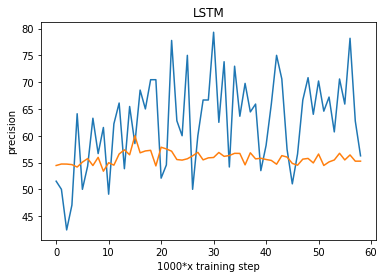

precision of the model on thevalidationdata: 55.65565490722656%
tensor([0.9537, 0.9516, 0.8169, 0.8368, 0.7618, 0.5627, 0.8954, 0.6516, 0.5589,
        0.7136, 0.6978, 0.5209, 0.8438, 0.8447, 0.8958, 0.6780, 0.6291, 0.8881,
        0.8981, 0.7762, 0.6764, 0.8266, 0.7933, 0.5397, 0.7450, 0.7206, 0.6969,
        0.7979, 0.5688, 0.6823, 0.7959, 0.6319, 0.6300, 0.9998, 0.7951, 0.5171,
        0.8043, 0.5761, 0.8277, 0.5434, 0.7297, 0.8247, 0.8948, 0.6992, 0.6468,
        0.5996, 0.9979, 0.6847, 0.6046, 0.7717, 0.5701, 0.7772, 0.5867, 0.5467,
        0.5523, 0.5255, 0.5198, 0.5634, 0.5306, 0.8198, 0.8102, 0.6169, 0.5022,
        0.8137, 0.6448, 0.6775, 0.6526, 0.8883, 0.6619, 0.7064, 0.6377, 0.5012,
        0.8134, 0.7503, 0.6841, 0.5401, 0.5003, 0.5009, 0.5093, 0.6478, 0.7091,
        0.6181, 0.6848, 0.5298, 0.6190, 0.7700, 0.7498, 0.6562, 0.6144, 0.5880,
        0.5192, 0.5327, 0.9670, 0.8887, 0.6103, 0.6926, 0.8230, 0.6314, 0.5461,
        0.6783], device='cuda:1')
current i is 48
Filter

precision of the model on thetrainingdata: 86.66666412353516%
precision of the model on thevalidationdata: 35.213829040527344%
precision of the model on thetrainingdata: 91.93548583984375%
precision of the model on thevalidationdata: 35.441688537597656%


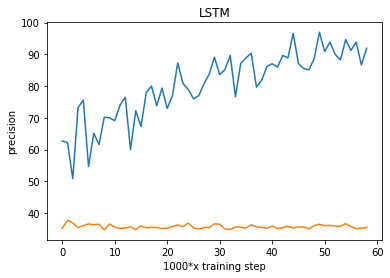

precision of the model on thevalidationdata: 36.53223419189453%
tensor([0.5416, 0.6183, 0.9212, 1.0000, 0.9979, 0.9907, 0.5078, 0.8593, 0.8691,
        0.9968, 0.9476, 0.9630, 0.9999, 0.9893, 0.5457, 0.9441, 0.8315, 0.8955,
        0.9909, 0.7342, 0.9992, 0.7794, 0.8220, 0.9998, 0.9639, 0.9912, 0.5206,
        0.7555, 0.5863, 0.8564, 0.9951, 0.8607, 0.9905, 0.7165, 0.8472, 0.8171,
        0.9954, 1.0000, 0.9026, 0.9998, 0.8274, 0.5526, 0.9986, 1.0000, 0.9859,
        0.8261, 0.9971, 0.9757, 0.9668, 0.6303, 0.9557, 0.8494, 0.9863, 0.9204,
        0.8555, 0.9636, 0.7241, 0.9456, 0.5590, 0.8549, 0.9915, 0.9604, 0.7625,
        0.6644, 0.5985, 0.9829, 0.6925, 0.9991, 0.9171, 0.7463, 0.9653, 0.8361,
        0.6218, 0.9068, 0.5970, 0.6909, 0.9958, 0.8946, 0.8094, 1.0000, 1.0000,
        0.9936, 0.8135, 0.9205, 0.7628, 0.9373, 0.5519, 0.9936, 0.8391, 0.9835,
        0.7998, 0.6125, 0.9940, 0.9996, 0.9846, 0.9037, 0.9021, 0.9664, 0.7587,
        0.9725], device='cuda:1')
current i is 49
Filter

precision of the model on thevalidationdata: 42.640533447265625%


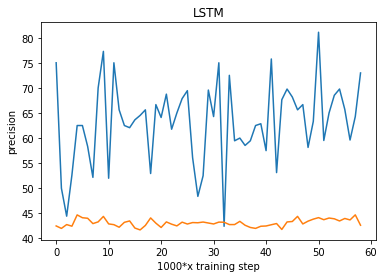

precision of the model on thevalidationdata: 43.55751037597656%
tensor([0.7285, 0.6905, 0.6906, 0.6560, 0.6429, 0.5085, 0.5769, 0.6317, 0.6366,
        0.7320, 0.5796, 0.6229, 0.5562, 0.5779, 0.9930, 0.6006, 0.5796, 0.5923,
        0.5380, 0.5612, 0.7528, 0.5512, 0.5021, 0.7571, 0.5356, 0.6194, 0.5821,
        0.6245, 0.5854, 0.9097, 0.5765, 0.5972, 0.6607, 0.5573, 0.6406, 0.7529,
        0.6152, 0.6957, 0.8738, 0.5091, 0.5095, 0.6419, 0.5460, 0.9947, 0.5687,
        0.5141, 0.6156, 0.7879, 0.7426, 0.5495, 0.6769, 0.7821, 0.7203, 0.5078,
        0.7828, 0.5712, 0.6889, 0.7662, 0.9687, 0.5544, 0.6552, 0.6568, 0.7543,
        0.8502, 0.6454, 0.7112, 0.6917, 0.5981, 0.7806, 0.7059, 0.5569, 0.8857,
        0.5838, 0.5375, 0.6293, 0.5804, 0.5124, 0.6588, 0.5270, 0.6955, 0.5463,
        0.7213, 0.7046, 0.6480, 0.5260, 0.6858, 0.8306, 0.8101, 0.6376, 0.5648,
        0.6369, 0.5659, 0.5197, 0.6309, 0.9691, 0.5263, 0.5382, 0.5381, 0.5812,
        0.5715], device='cuda:1')
current i is 50
Filter

precision of the model on thevalidationdata: 68.41004180908203%


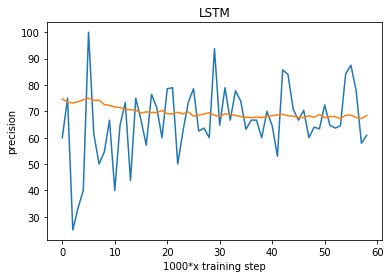

precision of the model on thevalidationdata: 68.67579650878906%
tensor([0.9990, 1.0000, 0.9749, 1.0000, 0.9348, 0.9982, 0.6743, 0.5283, 0.5510,
        0.9999, 0.9998, 0.8268, 0.7066, 0.6096, 0.6273, 1.0000, 0.9534, 0.9889,
        0.5205, 0.9784, 0.6813, 0.7681, 0.6717, 0.8422, 0.7524, 0.8023, 0.7062,
        0.5843, 0.6258, 0.8804, 0.7937, 0.5144, 0.8635, 0.8240, 0.7130, 0.6944,
        0.9919, 0.7285, 0.9998, 0.9410, 0.6393, 0.6025, 0.5245, 0.8828, 0.7905,
        0.5083, 0.8183, 0.7542, 0.7772, 0.5641, 1.0000, 0.9773, 0.8474, 0.6066,
        0.5446, 0.6303, 0.7722, 0.6160, 0.9762, 0.5800, 0.7685, 0.7621, 0.6725,
        0.8164, 0.9975, 0.9984, 1.0000, 0.5644, 0.9848, 0.9997, 0.7406, 0.9959,
        0.8443, 0.7937, 0.6267, 0.7786, 0.8225, 0.5295, 0.9950, 0.7369, 1.0000,
        0.7431, 0.7502, 0.6806, 0.9901, 0.8818, 0.8353, 0.6191, 0.6494, 0.9524,
        0.6958, 0.9985, 0.9990, 0.9401, 0.6629, 0.9987, 0.9980, 1.0000, 0.9946,
        0.9999], device='cuda:1')
current i is 51
Filter

precision of the model on thetrainingdata: 78.78787994384766%
precision of the model on thevalidationdata: 42.10894012451172%
precision of the model on thetrainingdata: 80.88235473632812%
precision of the model on thevalidationdata: 42.29403305053711%


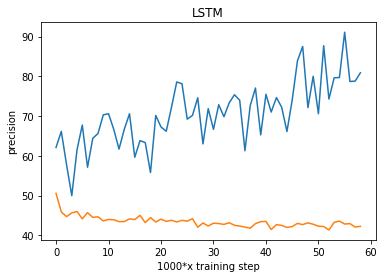

precision of the model on thevalidationdata: 42.753623962402344%
tensor([0.8806, 0.9054, 1.0000, 1.0000, 0.7160, 0.7317, 0.7180, 0.5597, 0.8387,
        0.5545, 0.5293, 0.6342, 0.6166, 0.9891, 0.5255, 1.0000, 0.6014, 0.9751,
        0.5919, 0.6082, 0.8838, 0.8992, 0.9229, 0.8109, 0.5947, 0.9997, 0.7039,
        0.8292, 0.7617, 0.9946, 1.0000, 0.8494, 0.8267, 0.8268, 0.6134, 1.0000,
        0.9945, 0.9527, 0.7851, 0.7331, 0.6027, 0.8042, 0.7271, 0.6701, 0.6583,
        0.9602, 0.9901, 0.9796, 0.8842, 0.9973, 0.8160, 0.6039, 0.5649, 0.9790,
        0.6878, 0.7871, 0.6841, 0.9491, 0.8770, 0.5643, 0.9658, 0.5334, 0.7560,
        0.7141, 0.5275, 0.5852, 0.6811, 0.5417, 0.7438, 0.7976, 0.9910, 0.6812,
        0.6434, 0.5225, 0.5373, 0.7033, 0.9158, 0.5707, 0.5318, 0.7637, 0.7955,
        0.6954, 0.5270, 0.5204, 0.9922, 0.6880, 0.5801, 0.5058, 0.5563, 0.9949,
        0.6888, 0.8370, 0.7575, 0.9565, 0.9574, 0.6614, 0.6437, 0.6883, 0.7031,
        0.5651], device='cuda:1')
current i is 52
Filte

precision of the model on thevalidationdata: 37.95660400390625%
precision of the model on thetrainingdata: 68.18181610107422%
precision of the model on thevalidationdata: 38.12709045410156%
precision of the model on thetrainingdata: 56.0%
precision of the model on thevalidationdata: 38.494754791259766%
precision of the model on thetrainingdata: 66.10169219970703%
precision of the model on thevalidationdata: 38.43547058105469%


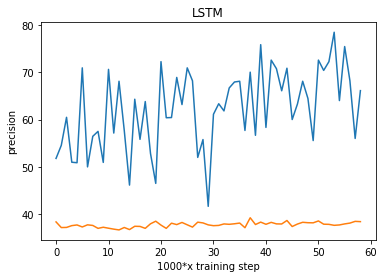

precision of the model on thevalidationdata: 38.061336517333984%
tensor([0.9950, 0.6798, 0.9683, 0.5065, 0.6305, 0.5349, 0.6033, 0.7047, 0.6753,
        0.5676, 0.8045, 0.5937, 1.0000, 0.5089, 0.7038, 0.9895, 1.0000, 0.5896,
        0.5850, 0.7889, 0.8942, 0.5335, 0.6929, 0.9987, 0.9928, 0.5519, 0.5913,
        0.7735, 1.0000, 1.0000, 0.8047, 0.9440, 0.5690, 0.9988, 0.7082, 0.6857,
        0.6274, 0.6462, 0.5900, 0.5072, 0.7867, 0.5176, 0.5340, 0.7115, 0.5645,
        0.6430, 0.5087, 0.8426, 0.9997, 1.0000, 0.6829, 0.6010, 0.5488, 0.7265,
        0.5084, 0.9893, 0.9041, 0.5190, 0.5685, 0.6531, 0.5864, 0.5945, 0.9640,
        0.9016, 0.6035, 0.7082, 0.8215, 0.6550, 0.7802, 0.6302, 0.5948, 0.6995,
        0.7790, 0.5692, 0.9214, 0.6761, 0.6300, 0.9287, 0.7705, 0.5505, 0.9968,
        0.8001, 0.6475, 0.7904, 0.6507, 0.9920, 0.9999, 1.0000, 0.9954, 0.9959,
        1.0000, 0.6864, 0.7989, 0.8282, 0.5397, 0.5575, 0.8109, 1.0000, 0.9994,
        0.8612], device='cuda:1')
current i is 54
Filte

precision of the model on thetrainingdata: 65.95744323730469%
precision of the model on thevalidationdata: 52.65306091308594%


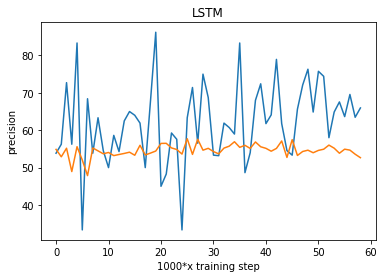

precision of the model on thevalidationdata: 54.63917541503906%
tensor([0.7252, 0.9491, 0.7586, 0.6125, 0.5471, 0.6291, 0.5288, 0.7155, 0.5644,
        0.6464, 0.5583, 0.5350, 0.7835, 0.5183, 0.6672, 0.6861, 0.5177, 0.7089,
        0.5599, 0.6444, 0.6525, 0.5620, 0.5493, 0.7455, 0.5560, 0.5263, 0.6684,
        0.7621, 0.5716, 0.6372, 0.5315, 0.5231, 0.6091, 0.7681, 0.7152, 0.8587,
        0.5014, 0.6719, 0.5657, 0.7376, 0.9994, 0.5963, 0.5438, 0.9991, 0.5236,
        0.5237, 0.7229, 0.9958, 0.8188, 0.6086, 0.5157, 0.5012, 0.5522, 0.5354,
        0.9934, 0.5976, 0.8629, 0.6017, 0.6085, 0.5101, 0.6603, 0.5521, 0.6879,
        0.5585, 0.6822, 1.0000, 0.8714, 0.5066, 0.5562, 0.5355, 0.5774, 0.7092,
        0.8126, 0.9259, 0.8882, 0.5705, 0.5731, 0.9055, 1.0000, 0.5465, 0.8453,
        0.5224, 0.5571, 0.5872, 0.6081, 0.5871, 0.7853, 0.6353, 0.6682, 0.8703,
        0.5393, 0.5825, 0.5038, 0.6164, 0.6499, 0.7668, 0.9990, 0.7097, 0.6179,
        0.7927], device='cuda:1')
current i is 55
Filter

precision of the model on thevalidationdata: 57.82634353637695%
precision of the model on thetrainingdata: 71.79486846923828%
precision of the model on thevalidationdata: 56.662513732910156%


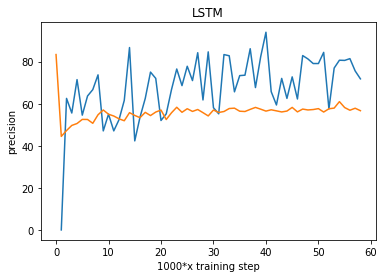

precision of the model on thevalidationdata: 57.13391876220703%
tensor([0.9989, 0.8158, 0.9998, 0.9996, 0.7247, 0.9371, 0.8361, 0.5381, 0.9999,
        1.0000, 0.7059, 0.5733, 0.9950, 0.9999, 0.5984, 0.8291, 0.8874, 0.7504,
        0.5662, 0.5760, 0.6921, 0.7452, 0.8094, 0.6825, 0.6082, 0.7129, 0.7517,
        0.7698, 0.7308, 0.9550, 0.8039, 0.6116, 0.5933, 0.6880, 0.8257, 0.6846,
        0.7898, 0.5651, 0.5669, 0.5478, 0.8818, 0.5867, 0.8998, 0.5384, 0.9689,
        0.7032, 0.9678, 0.9904, 0.7894, 0.9236, 0.8187, 0.5207, 0.6484, 0.7706,
        0.8197, 0.6652, 0.9955, 0.6624, 0.5964, 0.5467, 0.6268, 0.5215, 0.9951,
        0.8214, 0.9999, 0.9925, 0.6356, 0.5960, 0.7476, 0.6075, 0.5986, 0.6712,
        0.5067, 0.7152, 0.6909, 0.9999, 0.6043, 0.6540, 0.7300, 0.5110, 0.8461,
        0.8840, 0.9958, 0.6037, 0.5245, 0.5416, 0.8271, 0.8722, 0.6977, 0.8878,
        0.6900, 0.5811, 0.6641, 0.6094, 0.6788, 0.6549, 0.9264, 0.9157, 0.6090,
        0.9045], device='cuda:1')
current i is 56
Filter

precision of the model on thetrainingdata: 86.84210205078125%
precision of the model on thevalidationdata: 44.37869644165039%
precision of the model on thetrainingdata: 85.41666412353516%
precision of the model on thevalidationdata: 45.326087951660156%


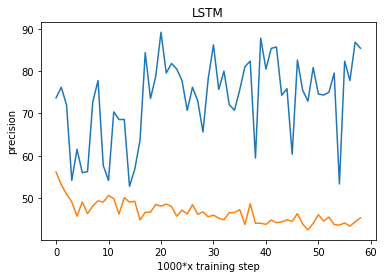

precision of the model on thevalidationdata: 43.72385025024414%
tensor([0.5093, 0.7481, 0.9211, 0.5821, 0.8979, 0.9970, 0.5595, 0.7718, 0.6104,
        0.5072, 0.6412, 0.9870, 0.5040, 0.8623, 0.8764, 0.9178, 0.9976, 0.6700,
        0.7801, 0.9304, 0.7568, 0.9177, 0.9980, 0.7897, 0.9539, 0.5748, 0.8139,
        0.9995, 0.8693, 0.6247, 0.9950, 0.8469, 0.5608, 0.7882, 0.9886, 0.7451,
        0.9776, 0.7054, 0.8412, 0.8668, 0.9741, 0.7302, 0.5140, 1.0000, 0.5064,
        0.8386, 0.5377, 0.8041, 0.8221, 0.9417, 0.9497, 0.9959, 0.7438, 0.9210,
        0.6643, 0.8258, 0.6221, 0.9999, 0.9092, 0.5267, 0.5700, 0.6799, 0.7831,
        0.9460, 0.7879, 0.9072, 0.5363, 0.9998, 0.7167, 0.9737, 0.8130, 0.7958,
        0.7210, 0.5635, 0.8027, 0.8307, 0.7155, 0.9651, 0.8795, 0.6042, 0.5641,
        1.0000, 0.8916, 0.5711, 0.5048, 0.8791, 0.9235, 0.5382, 0.9999, 0.6145,
        0.5835, 0.8418, 0.5136, 0.9953, 0.5331, 0.9983, 0.9048, 0.7788, 0.7095,
        0.9657], device='cuda:1')
current i is 57
Filter

precision of the model on thevalidationdata: 61.10466384887695%
precision of the model on thetrainingdata: 74.19355010986328%
precision of the model on thevalidationdata: 61.706207275390625%
precision of the model on thetrainingdata: 76.0%
precision of the model on thevalidationdata: 60.771400451660156%


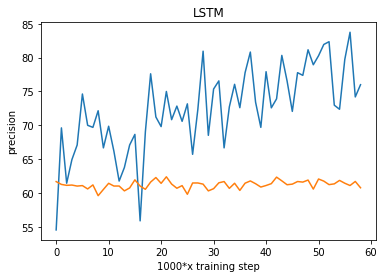

precision of the model on thevalidationdata: 61.35430908203125%
tensor([0.5519, 0.5052, 0.8207, 0.5323, 0.5817, 0.8029, 0.6274, 0.7380, 0.8991,
        0.5952, 0.5081, 0.5756, 0.9989, 0.9008, 0.7260, 0.9510, 0.5557, 0.7130,
        0.9898, 0.9642, 0.8516, 0.8519, 0.9647, 0.8443, 0.7212, 0.5771, 0.6241,
        0.6626, 0.9708, 0.9143, 0.7417, 0.6933, 0.7467, 0.8928, 0.9444, 0.5824,
        0.7504, 0.9971, 0.9374, 0.6853, 0.5387, 0.8848, 0.8927, 0.8475, 0.6445,
        0.7905, 0.9652, 0.6496, 0.6158, 0.6275, 0.9294, 0.8648, 0.5177, 0.7012,
        0.7585, 0.6220, 0.9334, 0.9711, 0.7622, 0.5130, 0.5836, 0.6737, 0.8596,
        0.6878, 0.6266, 0.9253, 0.6380, 0.6543, 0.6056, 0.5451, 0.8064, 0.5679,
        0.7381, 0.5255, 0.6073, 0.7907, 0.8250, 0.7342, 0.6276, 0.5735, 0.9670,
        0.6070, 0.9517, 0.5471, 0.9957, 0.9913, 0.8562, 0.9736, 0.7055, 0.5828,
        0.7133, 0.6757, 0.6940, 0.8683, 0.6501, 0.7516, 0.9995, 0.9079, 0.5593,
        0.6991], device='cuda:1')
current i is 58
Filter

precision of the model on thevalidationdata: 32.76414108276367%
precision of the model on thetrainingdata: 60.41666793823242%
precision of the model on thevalidationdata: 31.638212203979492%
precision of the model on thetrainingdata: 60.975608825683594%
precision of the model on thevalidationdata: 31.732545852661133%


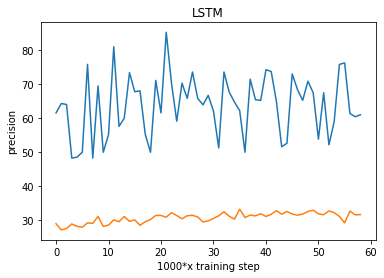

precision of the model on thevalidationdata: 30.787704467773438%
tensor([0.5397, 0.9968, 0.9687, 1.0000, 0.7700, 0.9845, 0.6135, 0.5764, 0.5106,
        0.5676, 0.6069, 0.5546, 0.6112, 0.6989, 0.7832, 0.6215, 0.8137, 0.5403,
        0.5274, 0.6241, 0.5893, 0.5099, 0.5756, 0.7742, 0.7738, 0.8612, 0.6481,
        0.8855, 0.9889, 0.9573, 0.6029, 0.8200, 0.7656, 0.5423, 0.6199, 0.5750,
        0.5292, 0.6288, 0.7196, 0.5529, 0.6784, 0.5142, 0.6117, 0.5259, 0.5403,
        0.6538, 0.5474, 0.9894, 0.6089, 0.5027, 0.7953, 0.8518, 0.7363, 0.5163,
        0.8133, 0.7593, 0.9987, 0.5046, 0.7210, 0.9572, 0.6608, 0.5738, 0.6035,
        0.5634, 0.7011, 0.5667, 0.6195, 0.7623, 0.5921, 0.7069, 0.6134, 0.9912,
        0.8869, 1.0000, 0.7747, 0.7389, 0.6210, 0.9454, 1.0000, 0.5322, 0.7680,
        0.6017, 0.8538, 0.6017, 0.6525, 0.5587, 0.5092, 0.6160, 0.7718, 0.7578,
        0.7226, 0.7083, 0.5135, 0.5608, 0.6605, 0.7562, 0.5278, 0.8751, 0.6439,
        0.8465], device='cuda:1')
current i is 59
Filte

precision of the model on thevalidationdata: 36.90237808227539%
precision of the model on thetrainingdata: 77.08333587646484%
precision of the model on thevalidationdata: 36.6992073059082%
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 36.67679977416992%


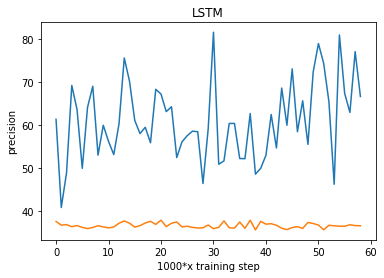

precision of the model on thevalidationdata: 36.6263427734375%
tensor([0.5182, 0.6472, 0.6512, 0.6600, 0.5106, 0.5795, 0.7430, 0.6541, 0.8885,
        0.6456, 0.5203, 0.6453, 0.8437, 0.8599, 0.6819, 0.7689, 0.5992, 0.6348,
        0.7770, 0.6502, 0.5577, 0.6382, 0.5735, 0.6589, 0.8168, 0.5106, 0.6063,
        0.5019, 0.6978, 0.5318, 0.5428, 0.6454, 0.7188, 0.6626, 0.7353, 0.5141,
        0.7919, 0.5563, 0.5366, 0.5763, 0.6554, 0.5445, 0.5190, 0.6891, 0.8662,
        0.6049, 0.5726, 0.7799, 0.5921, 0.9772, 0.8255, 0.7286, 0.6496, 0.7027,
        0.8431, 0.6701, 0.5455, 0.5775, 0.5841, 0.6451, 0.9897, 0.5935, 0.5959,
        0.5098, 0.9840, 0.5981, 0.5480, 0.6226, 0.6159, 0.5799, 0.7288, 0.7017,
        1.0000, 0.5498, 0.6999, 0.5818, 0.5145, 0.9753, 0.9710, 0.5082, 0.5025,
        0.5153, 0.5222, 0.6950, 0.8847, 0.7165, 0.5522, 0.5456, 0.6892, 0.5284,
        0.6409, 0.5402, 0.9125, 0.9915, 0.6522, 0.6542, 0.9905, 0.6090, 0.6414,
        0.7004], device='cuda:1')
current i is 60
Filter 

precision of the model on thevalidationdata: 37.83363723754883%
precision of the model on thetrainingdata: 63.75%
precision of the model on thevalidationdata: 36.67971420288086%
precision of the model on thetrainingdata: 62.85714340209961%
precision of the model on thevalidationdata: 36.862953186035156%


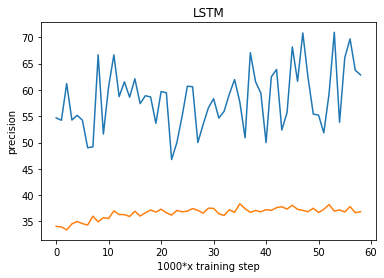

precision of the model on thevalidationdata: 37.15807342529297%
tensor([0.6189, 0.6260, 0.6878, 0.5954, 0.5523, 0.6573, 0.5698, 0.5933, 0.6398,
        0.6628, 0.8183, 0.5021, 0.5157, 0.5220, 0.5288, 0.5576, 0.6479, 0.5689,
        0.6351, 0.5629, 0.5299, 0.5871, 0.7948, 0.8594, 0.5212, 0.5162, 0.5963,
        0.5632, 0.7840, 0.6439, 1.0000, 0.5517, 1.0000, 0.5263, 0.6038, 0.7895,
        0.5595, 0.7429, 0.6235, 0.5542, 0.5012, 0.5851, 0.5094, 1.0000, 1.0000,
        0.9687, 0.7215, 0.6000, 0.6991, 0.8671, 0.5204, 0.7496, 0.5740, 0.5937,
        0.5500, 0.7877, 0.6536, 0.9957, 0.5143, 0.8282, 0.5754, 0.7006, 0.9885,
        0.9811, 0.6770, 0.8851, 1.0000, 0.7789, 0.5460, 0.7818, 0.6040, 0.7328,
        0.5601, 0.9048, 1.0000, 1.0000, 0.5648, 0.5847, 0.6415, 0.7008, 0.5474,
        0.6895, 0.5594, 0.6931, 0.5922, 0.5086, 0.8489, 0.5233, 0.6037, 0.5481,
        0.7577, 0.6362, 0.5498, 0.5321, 0.6100, 0.9993, 0.9590, 0.5123, 1.0000,
        1.0000], device='cuda:1')
current i is 61
Filter

precision of the model on thevalidationdata: 57.281776428222656%
precision of the model on thetrainingdata: 92.1568603515625%
precision of the model on thevalidationdata: 58.5470085144043%


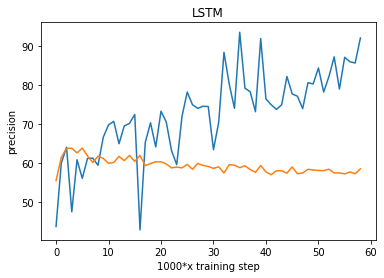

precision of the model on thevalidationdata: 58.23045349121094%
tensor([0.7713, 0.7412, 0.5208, 0.9120, 0.8108, 0.9999, 0.5218, 0.6471, 0.9824,
        0.6969, 0.9999, 0.9679, 0.6716, 0.5359, 0.6644, 0.9647, 0.9137, 1.0000,
        0.6677, 0.6216, 0.7693, 0.6961, 1.0000, 0.7156, 0.9986, 0.9981, 0.9820,
        0.9764, 0.9928, 0.9997, 0.5893, 0.5185, 0.9696, 0.9981, 0.9970, 0.5679,
        0.8475, 0.9998, 0.9545, 0.9108, 0.6126, 0.7965, 1.0000, 0.8517, 0.9999,
        0.7342, 0.9671, 0.7022, 0.6669, 0.7064, 0.7035, 0.8293, 0.7524, 0.5633,
        0.7587, 0.9624, 0.6824, 0.7897, 0.9896, 0.8082, 0.5673, 0.7157, 0.8711,
        0.9346, 0.7075, 0.7189, 1.0000, 0.9999, 1.0000, 1.0000, 0.9997, 0.9967,
        0.5362, 0.9971, 0.9930, 0.9991, 0.7236, 0.8813, 0.7360, 0.9988, 0.6579,
        0.9863, 0.9037, 0.9437, 0.9689, 0.9998, 0.5417, 1.0000, 0.9730, 0.9492,
        0.8454, 0.7299, 0.5667, 0.6621, 0.9936, 0.9402, 0.9762, 1.0000, 0.8885,
        0.9195], device='cuda:1')
current i is 62
Filter

precision of the model on thetrainingdata: 84.61538696289062%
precision of the model on thevalidationdata: 22.362960815429688%
precision of the model on thetrainingdata: 77.19298553466797%
precision of the model on thevalidationdata: 22.375690460205078%


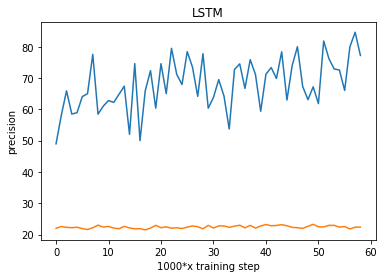

precision of the model on thevalidationdata: 21.957914352416992%
tensor([0.5039, 0.7993, 0.7010, 0.5424, 0.5601, 0.7337, 0.8723, 0.7166, 0.6544,
        0.5320, 0.5597, 0.7139, 0.8403, 0.5675, 0.8575, 0.9495, 0.7749, 0.6014,
        0.7884, 0.9946, 0.9985, 0.8988, 0.8723, 0.9272, 0.5321, 0.7476, 0.7267,
        0.5510, 0.6430, 0.5397, 0.5886, 0.5084, 0.5280, 0.6713, 0.6436, 0.5832,
        0.6207, 0.9983, 0.6607, 0.9987, 0.9475, 0.9487, 0.7024, 0.7710, 0.5395,
        0.5405, 0.5654, 0.9341, 0.8889, 0.8566, 0.9333, 0.5782, 0.8212, 0.7225,
        0.5908, 0.6970, 0.5684, 0.5984, 0.5377, 0.9208, 0.9267, 0.6040, 0.5399,
        0.5035, 0.8612, 0.6759, 0.5851, 0.5980, 0.5332, 0.7252, 0.7721, 0.6551,
        0.6075, 0.5784, 0.7360, 0.8936, 0.6717, 0.7495, 0.6265, 0.7915, 0.7948,
        0.7743, 0.9679, 0.5868, 0.5071, 0.5362, 0.6177, 0.8710, 0.5808, 0.9484,
        0.7560, 0.5027, 0.7816, 0.7764, 0.8822, 0.8457, 0.6760, 0.6428, 0.6476,
        0.8409], device='cuda:1')
current i is 63
Filte

precision of the model on thetrainingdata: 83.63636016845703%
precision of the model on thevalidationdata: 44.617225646972656%
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 45.30950927734375%


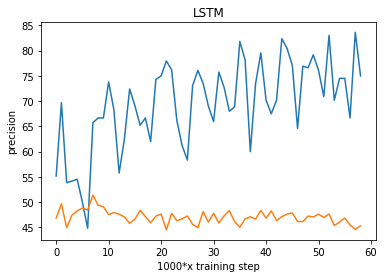

precision of the model on thevalidationdata: 45.508392333984375%
tensor([0.7577, 0.7013, 0.7326, 0.9995, 0.9998, 0.9433, 0.6570, 0.7499, 0.6421,
        0.5816, 0.8844, 0.7934, 0.8167, 0.7062, 0.9783, 0.6903, 0.7185, 0.9999,
        0.5460, 0.6472, 0.7399, 0.5605, 0.8580, 0.6666, 0.6204, 0.5243, 0.5713,
        0.5171, 0.6799, 0.9045, 0.5893, 0.8126, 0.8821, 0.9146, 0.9726, 0.7576,
        0.9793, 0.5581, 0.9992, 0.6123, 0.7264, 0.5819, 0.5820, 0.6060, 0.8087,
        0.7094, 0.7197, 0.6100, 0.8077, 0.9145, 0.9351, 0.6252, 0.8598, 0.5382,
        0.6090, 0.5647, 0.5129, 0.9979, 0.9979, 0.9999, 0.6330, 0.8355, 0.7602,
        0.6009, 0.8720, 0.9503, 0.5011, 0.9957, 0.9994, 0.9510, 0.9928, 0.9990,
        0.6494, 0.5520, 0.7461, 0.5936, 0.7530, 0.5134, 0.8936, 0.9361, 0.5133,
        0.5408, 0.5111, 0.5148, 0.5337, 0.9175, 0.9986, 0.6943, 0.5982, 0.5362,
        0.7456, 0.8223, 0.5568, 0.6302, 0.8109, 0.7384, 0.7842, 0.9460, 0.9971,
        0.5390], device='cuda:1')
current i is 64
Filte

precision of the model on thetrainingdata: 77.55101776123047%
precision of the model on thevalidationdata: 40.04090118408203%
precision of the model on thetrainingdata: 56.3636360168457%
precision of the model on thevalidationdata: 38.906883239746094%


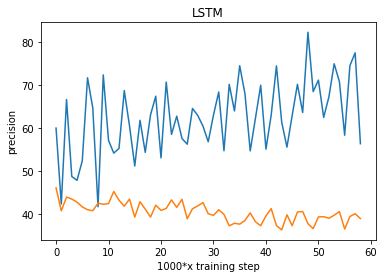

precision of the model on thevalidationdata: 37.96555709838867%
tensor([0.5945, 0.6231, 0.8126, 0.6314, 0.5963, 0.5253, 0.5165, 0.7577, 0.5127,
        0.6777, 0.5693, 0.7356, 0.7368, 0.5366, 0.5963, 0.6569, 0.7236, 0.6036,
        0.5099, 0.5955, 0.5201, 0.5230, 0.5592, 0.6882, 0.5058, 0.5249, 0.5992,
        0.6367, 0.5377, 0.5831, 0.5142, 0.6712, 0.6858, 0.5506, 0.6562, 0.7944,
        0.6905, 0.6737, 0.7337, 0.5917, 0.5413, 0.5450, 0.5735, 0.6492, 0.6669,
        0.6361, 0.6399, 0.5788, 0.5265, 0.5706, 0.5038, 0.5772, 0.9767, 0.6432,
        0.5345, 0.5566, 0.5392, 0.7150, 0.5173, 0.7422, 0.7502, 0.6526, 0.5267,
        0.7150, 0.6173, 0.6249, 0.7775, 0.5483, 0.6938, 0.5736, 0.6075, 0.7113,
        0.7088, 0.5249, 0.5889, 0.5214, 0.6544, 0.5720, 0.5254, 0.7382, 0.6208,
        0.5052, 0.6556, 0.6612, 0.7327, 0.6473, 0.8277, 0.7327, 0.5985, 0.6240,
        0.8105, 0.5824, 0.5139, 0.5725, 0.7800, 0.7727, 0.6224, 0.6810, 0.5782,
        0.6406], device='cuda:1')
current i is 65
Filter

precision of the model on thevalidationdata: 49.13397979736328%
precision of the model on thetrainingdata: 72.4137954711914%
precision of the model on thevalidationdata: 49.671051025390625%


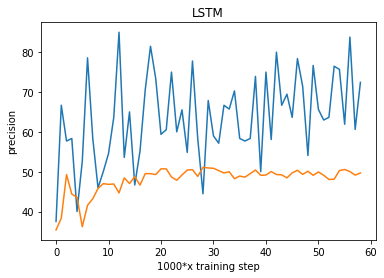

precision of the model on thevalidationdata: 49.72269058227539%
tensor([0.5159, 0.8940, 0.9947, 0.9999, 0.7806, 0.9983, 0.9802, 0.6439, 0.5419,
        1.0000, 0.5917, 0.8381, 0.5002, 0.7390, 0.8760, 0.9375, 0.5439, 0.7061,
        0.6172, 0.9977, 0.9999, 0.9998, 0.5882, 0.9857, 0.9840, 0.9998, 0.9880,
        0.9995, 0.9982, 0.9998, 0.5544, 0.6698, 0.9955, 0.9989, 0.9999, 0.6257,
        0.5366, 1.0000, 0.9943, 0.9744, 0.8019, 0.9074, 0.5493, 1.0000, 0.9999,
        0.9989, 0.5494, 0.5141, 0.7308, 0.7806, 0.9530, 0.9982, 0.8963, 0.9646,
        0.6665, 0.8279, 0.9253, 0.5739, 0.5761, 0.9994, 0.5919, 0.6530, 0.6913,
        0.9633, 0.9999, 0.9706, 0.8862, 0.8768, 0.7688, 0.8165, 0.7364, 0.9975,
        0.9977, 0.9984, 0.9997, 0.9920, 0.5153, 0.6231, 0.5530, 0.9994, 0.6730,
        0.5286, 0.8498, 1.0000, 1.0000, 0.5413, 0.9992, 0.6245, 0.5696, 0.5824,
        0.9972, 0.5993, 0.8384, 0.5291, 0.8249, 1.0000, 0.5775, 0.5851, 0.5353,
        0.8500], device='cuda:1')
current i is 66
Filter

precision of the model on thetrainingdata: 90.32257843017578%
precision of the model on thevalidationdata: 63.343223571777344%
precision of the model on thetrainingdata: 88.57142639160156%
precision of the model on thevalidationdata: 63.47726821899414%


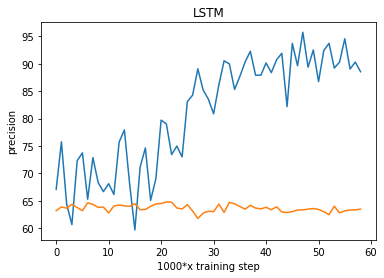

precision of the model on thevalidationdata: 63.98564529418945%
tensor([0.7977, 0.9993, 1.0000, 0.7605, 0.9379, 0.9073, 0.6836, 0.9155, 1.0000,
        0.5499, 0.9677, 0.9179, 0.7016, 0.9936, 1.0000, 0.7562, 0.9580, 0.8677,
        0.9295, 0.9410, 0.8389, 0.7498, 0.9989, 0.8543, 0.7240, 0.8261, 0.9864,
        0.6499, 0.9627, 0.9992, 0.7985, 0.9446, 0.9809, 0.6126, 0.6021, 0.5695,
        0.7905, 0.5537, 0.8580, 0.9975, 0.9324, 0.8176, 0.8406, 0.9932, 0.8855,
        0.9837, 0.9830, 0.9947, 0.7090, 0.9879, 0.9790, 0.7112, 0.8475, 0.9946,
        0.9488, 0.8894, 0.5894, 0.8361, 0.8829, 0.8824, 0.6615, 0.9040, 0.9343,
        0.6788, 0.9329, 0.8724, 0.5992, 0.9999, 0.9952, 0.9146, 0.5001, 0.8861,
        0.8220, 0.9849, 0.8320, 0.9900, 0.9999, 0.7548, 0.8613, 0.9992, 0.9937,
        0.9993, 0.8726, 0.7659, 0.7445, 0.7677, 0.9680, 0.9505, 0.6365, 0.7465,
        0.8279, 0.9938, 0.9665, 0.9938, 0.7326, 0.8581, 0.9935, 0.9622, 0.9995,
        0.9886], device='cuda:1')
current i is 67
Filter

precision of the model on thetrainingdata: 58.57143020629883%
precision of the model on thevalidationdata: 17.03521728515625%
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 17.755573272705078%


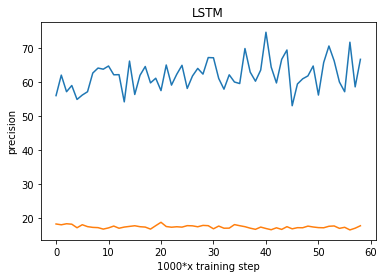

precision of the model on thevalidationdata: 17.088607788085938%
tensor([0.5741, 0.6070, 0.6531, 0.5065, 0.8867, 0.5284, 1.0000, 0.8950, 0.6529,
        0.5705, 0.5055, 0.5531, 0.5044, 0.5675, 0.6429, 0.9215, 0.8941, 0.5923,
        0.6475, 0.5800, 0.5544, 0.6478, 0.8962, 0.5244, 0.7820, 0.7054, 0.8619,
        0.5946, 0.5898, 0.5096, 0.8134, 0.7952, 0.7405, 0.9761, 0.5526, 0.8161,
        0.6020, 0.9316, 0.8547, 0.6015, 0.5400, 0.6049, 0.9680, 0.5821, 0.6239,
        0.5413, 0.9826, 0.8806, 0.5500, 0.6717, 0.6926, 0.5780, 0.6229, 0.6994,
        0.7806, 0.7483, 0.5316, 0.5101, 0.8174, 0.7054, 0.7640, 0.5879, 0.8599,
        0.8467, 0.9833, 0.6177, 0.9676, 0.7006, 0.5433, 0.5813, 0.9515, 0.6423,
        0.9754, 0.6859, 0.7035, 0.5161, 0.5727, 0.5035, 0.5834, 0.7089, 0.5740,
        0.6884, 0.5128, 0.5044, 0.9367, 0.6200, 0.9672, 0.8178, 0.9207, 0.6078,
        0.5550, 0.5738, 0.6101, 0.5812, 0.6156, 0.8525, 0.7328, 0.5955, 0.5114,
        0.5529], device='cuda:1')
current i is 68
Filte

precision of the model on thetrainingdata: 58.13953399658203%
precision of the model on thevalidationdata: 27.677928924560547%
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 29.281768798828125%


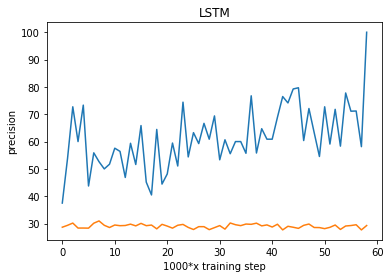

precision of the model on thevalidationdata: 27.80172348022461%
tensor([0.8241, 0.9563, 0.6100, 0.6078, 0.6763, 0.9363, 0.7881, 0.5345, 0.5281,
        0.9741, 0.5774, 1.0000, 0.7798, 0.5270, 0.9779, 0.5658, 0.8777, 0.6525,
        0.9991, 0.7248, 0.9722, 0.5621, 0.5714, 0.9986, 0.6276, 0.7189, 0.7033,
        0.7171, 0.7045, 0.5157, 0.7341, 0.6259, 0.9569, 0.6512, 0.6121, 0.6136,
        0.5105, 0.6649, 0.8321, 0.5392, 0.5160, 0.6278, 0.6530, 0.5059, 0.5461,
        0.5605, 0.5470, 0.5342, 0.6038, 0.7647, 0.6660, 0.7070, 0.7123, 0.7599,
        0.5530, 0.6440, 0.6336, 0.5845, 0.5563, 0.5583, 0.8703, 0.6622, 0.9993,
        0.5198, 0.7951, 0.5742, 0.8075, 0.5959, 0.5647, 0.7128, 0.5363, 0.6928,
        0.6820, 0.6018, 0.8334, 0.5202, 0.7210, 0.5051, 0.7062, 0.9938, 0.6171,
        0.5639, 0.9462, 0.9356, 0.6523, 1.0000, 0.8599, 0.5527, 0.9986, 0.5094,
        0.5012, 0.6304, 0.5638, 0.5800, 0.7308, 0.5461, 0.5903, 0.5839, 0.7381,
        0.7814], device='cuda:1')
current i is 69
Filter

precision of the model on thevalidationdata: 43.81874084472656%
precision of the model on thetrainingdata: 76.19047546386719%
precision of the model on thevalidationdata: 45.15198516845703%
precision of the model on thetrainingdata: 67.7966079711914%
precision of the model on thevalidationdata: 44.36531066894531%


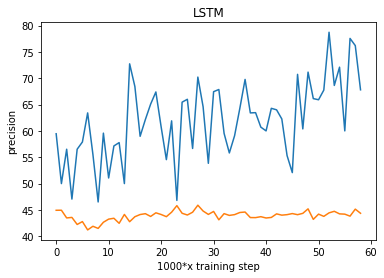

precision of the model on thevalidationdata: 44.14796829223633%
tensor([1.0000, 0.5231, 0.5279, 1.0000, 0.8983, 0.6095, 0.7375, 0.5589, 0.9287,
        0.6114, 0.9995, 0.8932, 1.0000, 0.9466, 1.0000, 0.7278, 0.5690, 0.5509,
        0.6300, 0.6961, 0.6482, 1.0000, 0.9093, 0.5762, 0.6354, 1.0000, 0.9960,
        0.9977, 0.7552, 0.9890, 1.0000, 1.0000, 0.9999, 1.0000, 0.8123, 0.7731,
        0.9906, 0.5378, 0.9897, 0.9995, 0.6933, 0.5886, 0.8431, 0.6073, 0.5516,
        0.9840, 0.5755, 0.5782, 0.6636, 0.7891, 1.0000, 0.9854, 1.0000, 0.9812,
        0.9702, 0.5510, 0.7816, 0.9944, 0.9972, 0.9991, 1.0000, 0.6292, 0.5895,
        0.5986, 0.6565, 0.8160, 0.6906, 0.7948, 0.8207, 0.5328, 0.8520, 0.5300,
        0.9369, 0.8994, 0.5202, 1.0000, 0.9998, 0.9933, 1.0000, 0.6916, 0.9085,
        0.6929, 1.0000, 1.0000, 0.8049, 0.5654, 0.7137, 0.5540, 0.5064, 0.7280,
        0.5764, 0.6345, 0.6294, 0.9949, 0.6195, 0.9786, 0.5673, 0.5137, 0.6722,
        1.0000], device='cuda:1')
current i is 70
Filter

precision of the model on thetrainingdata: 63.88888931274414%
precision of the model on thevalidationdata: 83.2066879272461%


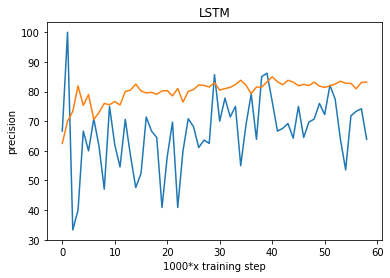

precision of the model on thevalidationdata: 83.34636688232422%
tensor([0.9999, 0.9606, 0.9160, 0.8877, 0.5446, 0.5946, 0.8167, 0.7878, 0.9899,
        0.6068, 0.7901, 0.6245, 0.5478, 0.6983, 0.9620, 0.7021, 0.5045, 0.6574,
        0.5365, 0.6648, 0.7844, 0.5344, 0.8724, 0.9971, 0.9033, 0.7774, 0.7381,
        0.7588, 0.7244, 0.6860, 0.8575, 0.6151, 0.8505, 0.5562, 0.8685, 0.6474,
        0.8839, 0.5492, 0.9322, 0.6030, 0.6758, 0.5972, 0.9217, 0.9999, 0.9975,
        0.5239, 0.9104, 0.7240, 0.9280, 0.9978, 0.8487, 0.7791, 0.7925, 0.6452,
        0.9561, 0.6547, 0.7848, 0.5007, 0.5609, 0.5262, 0.9867, 0.9984, 0.8730,
        0.5868, 0.9649, 0.6264, 0.7051, 0.7080, 0.7083, 0.7526, 0.9290, 0.8296,
        0.8941, 0.5872, 0.8535, 0.7659, 0.8411, 0.5716, 0.9970, 0.5919, 0.5561,
        0.8148, 0.5580, 0.6885, 0.7350, 0.7237, 0.6272, 0.5743, 0.7001, 0.6596,
        0.8976, 0.6476, 0.5190, 0.5361, 0.8576, 0.8721, 0.9927, 0.9187, 0.7153,
        0.7832], device='cuda:1')
current i is 71
Filter

precision of the model on thevalidationdata: 42.07830047607422%
precision of the model on thetrainingdata: 75.4385986328125%
precision of the model on thevalidationdata: 41.56711196899414%
precision of the model on thetrainingdata: 74.35897064208984%
precision of the model on thevalidationdata: 41.85798263549805%


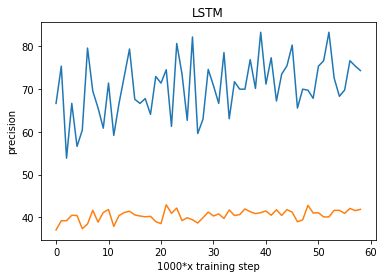

precision of the model on thevalidationdata: 40.234859466552734%
tensor([0.5673, 0.7920, 0.5194, 0.5656, 0.7959, 0.5736, 0.8030, 0.8212, 0.6531,
        0.5510, 0.6202, 0.6954, 0.5194, 0.6834, 0.5082, 0.7676, 0.9519, 0.5965,
        0.5743, 0.7263, 0.6560, 0.5864, 0.9432, 0.8436, 0.6784, 0.7306, 0.6020,
        0.6379, 0.5794, 0.7754, 0.7387, 0.7067, 0.8076, 0.5704, 0.5484, 0.9472,
        0.7567, 0.6308, 0.7137, 0.5627, 0.8499, 0.7093, 0.5601, 0.7047, 0.6272,
        0.6622, 0.8535, 0.7089, 0.7395, 0.6081, 0.7087, 0.7883, 0.5939, 0.6033,
        0.6716, 0.5808, 0.7573, 0.8036, 0.7637, 0.6384, 0.7324, 0.7307, 0.5433,
        0.6963, 0.6998, 0.6065, 0.7247, 0.9019, 0.6675, 0.7001, 0.5529, 0.5480,
        0.6764, 0.7388, 0.8585, 0.6538, 0.7578, 0.7400, 0.5619, 0.5983, 0.7869,
        0.6619, 0.5092, 0.5166, 0.6568, 0.7198, 0.6431, 0.9448, 0.5164, 0.6459,
        0.6751, 0.8326, 0.7446, 0.5142, 0.9444, 0.7529, 0.8493, 0.6840, 0.6434,
        0.9153], device='cuda:1')
current i is 72
Filte

precision of the model on thevalidationdata: 45.84885025024414%
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 46.95155334472656%
precision of the model on thetrainingdata: 76.19047546386719%
precision of the model on thevalidationdata: 46.878482818603516%


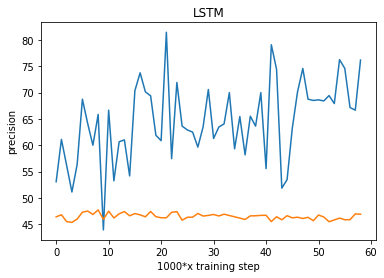

precision of the model on thevalidationdata: 46.183902740478516%
tensor([0.6074, 0.6306, 0.7199, 0.5066, 0.5044, 0.5931, 0.6157, 0.5363, 0.7845,
        0.6125, 0.7941, 0.6923, 0.5388, 0.5823, 0.9171, 0.7324, 0.8662, 0.5395,
        0.8018, 0.8634, 0.6935, 0.6690, 0.7681, 0.6511, 0.6074, 0.7360, 0.6467,
        0.9563, 0.6547, 0.7503, 0.6443, 0.9102, 0.7422, 0.9735, 0.9379, 0.9956,
        0.8551, 0.7063, 0.6776, 0.9972, 1.0000, 0.5899, 0.6681, 0.9998, 0.5253,
        0.9993, 0.9989, 0.7684, 0.5358, 0.6574, 0.6691, 0.5690, 0.5789, 0.7145,
        0.5443, 0.6912, 0.6727, 0.9998, 0.8262, 0.5545, 0.7252, 0.7340, 0.6553,
        0.6340, 0.7204, 0.6981, 0.5699, 0.6969, 0.6815, 0.9838, 0.9986, 0.9964,
        0.9301, 0.9845, 0.9719, 0.6340, 0.7974, 0.5173, 0.6734, 0.6007, 0.6883,
        0.6548, 0.6607, 0.5009, 0.9377, 0.9703, 0.6396, 0.7618, 0.8022, 0.5489,
        0.9286, 0.9120, 0.9909, 0.6213, 0.5348, 0.5847, 0.7096, 0.5298, 0.6691,
        0.6198], device='cuda:1')
current i is 73
Filte

precision of the model on thetrainingdata: 71.15384674072266%
precision of the model on thevalidationdata: 36.78702163696289%
precision of the model on thetrainingdata: 67.2727279663086%
precision of the model on thevalidationdata: 35.401973724365234%


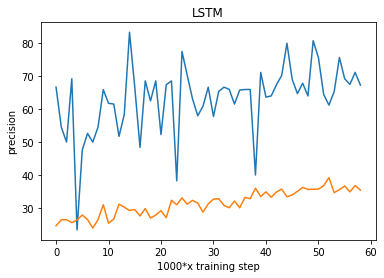

precision of the model on thevalidationdata: 34.979610443115234%
tensor([0.5563, 0.8012, 0.5240, 0.6817, 0.6520, 0.6481, 0.6016, 0.6895, 0.5697,
        0.6619, 0.6970, 0.5031, 0.5061, 0.6386, 0.6652, 0.5703, 0.7845, 0.6325,
        0.6447, 0.5946, 0.5586, 0.6233, 0.5429, 0.6848, 0.6733, 0.5633, 0.5079,
        0.5073, 0.5106, 0.7758, 0.6431, 0.5337, 0.5743, 0.6551, 0.7371, 0.5382,
        0.6711, 0.8416, 0.6920, 0.6528, 0.5514, 0.6874, 0.7864, 0.5232, 0.5575,
        0.8094, 0.6637, 0.7016, 0.5085, 0.7463, 0.7293, 0.7206, 0.5365, 0.7465,
        0.6854, 0.6174, 0.6887, 0.5677, 0.6028, 0.5243, 0.6035, 0.5557, 0.8039,
        0.8287, 0.5539, 0.6222, 0.6243, 0.6844, 0.9115, 0.6206, 0.6052, 0.6226,
        0.5954, 0.5104, 0.5954, 0.6157, 0.5883, 0.5292, 0.5878, 0.5974, 0.5904,
        0.7304, 0.7306, 0.5639, 0.7258, 0.6847, 0.5455, 0.6719, 0.5107, 0.5618,
        0.6382, 0.7023, 0.5279, 0.8451, 0.7068, 0.6369, 0.6065, 0.5163, 0.5698,
        0.7074], device='cuda:1')
current i is 74
Filte

precision of the model on thetrainingdata: 75.51020050048828%
precision of the model on thevalidationdata: 55.86530685424805%
precision of the model on thetrainingdata: 66.66666412353516%
precision of the model on thevalidationdata: 56.57381057739258%


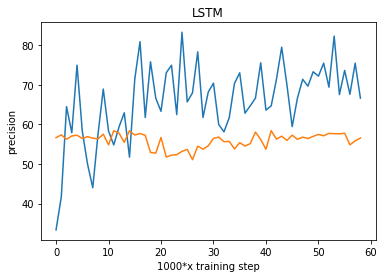

precision of the model on thevalidationdata: 56.480445861816406%
tensor([0.7084, 0.5304, 0.7384, 0.9854, 1.0000, 0.7767, 1.0000, 0.9999, 0.5472,
        0.9856, 0.9843, 0.5014, 1.0000, 1.0000, 0.6510, 0.9925, 1.0000, 0.6643,
        1.0000, 1.0000, 1.0000, 1.0000, 0.5415, 0.7725, 0.7009, 1.0000, 0.7008,
        0.9957, 0.9868, 0.5159, 0.8806, 0.9998, 0.9992, 0.5198, 0.8587, 1.0000,
        0.9733, 0.7541, 1.0000, 0.8089, 0.5205, 0.9595, 0.9704, 0.9685, 0.9002,
        0.9647, 0.7560, 0.6407, 0.9097, 1.0000, 0.8581, 0.8588, 0.7949, 0.9891,
        0.6134, 0.9832, 1.0000, 0.8878, 0.9817, 0.9994, 0.8924, 0.9999, 1.0000,
        0.9700, 1.0000, 0.6190, 0.9395, 1.0000, 1.0000, 0.9942, 0.8848, 0.9927,
        0.8083, 0.7844, 0.9154, 1.0000, 0.9998, 0.9992, 1.0000, 0.5233, 1.0000,
        0.9994, 0.8721, 0.5791, 0.9287, 0.8985, 0.9893, 1.0000, 0.7848, 0.6399,
        0.8294, 0.6918, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6583, 1.0000,
        0.9997], device='cuda:1')
current i is 75
Filte

precision of the model on thetrainingdata: 69.8630142211914%
precision of the model on thevalidationdata: 40.71052169799805%
precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 41.3662223815918%


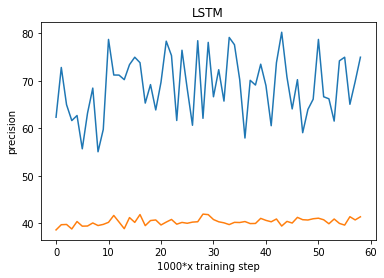

precision of the model on thevalidationdata: 40.1727180480957%
tensor([0.6923, 0.6552, 0.6111, 0.6589, 0.5738, 0.8358, 0.5898, 0.5125, 0.6566,
        0.7757, 0.5121, 0.5340, 0.5609, 0.6128, 0.5592, 0.5716, 0.5497, 0.5062,
        0.7782, 0.5671, 0.7212, 0.7400, 0.5048, 0.5687, 0.8421, 0.6117, 0.7968,
        0.8288, 0.6640, 0.6986, 0.5521, 0.6191, 0.6332, 0.6812, 0.6615, 0.5560,
        0.5288, 0.5118, 0.7778, 0.7465, 0.7614, 0.6818, 0.5135, 0.5122, 0.5489,
        0.8025, 0.6026, 0.5623, 0.6024, 0.7823, 0.5418, 0.6476, 0.5332, 0.6439,
        0.5457, 0.5680, 0.6147, 0.7618, 0.5170, 0.6832, 0.7256, 0.6478, 0.6569,
        0.8287, 0.6266, 0.5808, 0.6194, 0.5845, 0.6296, 0.7945, 0.6536, 0.7530,
        0.8336, 0.5351, 0.5827, 0.5809, 0.7533, 0.5220, 0.7507, 0.7513, 0.6994,
        0.5265, 0.6379, 0.7707, 0.8536, 0.5819, 0.6736, 0.5061, 0.7007, 0.5215,
        0.6231, 0.5040, 0.5811, 0.7959, 0.5767, 0.5355, 0.7894, 0.8391, 0.7868,
        0.5993], device='cuda:1')
current i is 76
Filter 

precision of the model on thevalidationdata: 52.819549560546875%
precision of the model on thetrainingdata: 65.21739196777344%
precision of the model on thevalidationdata: 52.606231689453125%
precision of the model on thetrainingdata: 74.0740737915039%
precision of the model on thevalidationdata: 52.34675598144531%


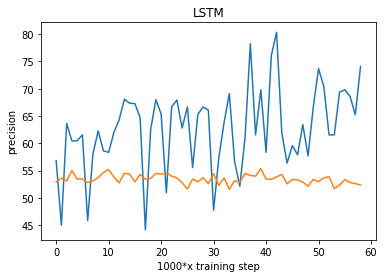

precision of the model on thevalidationdata: 52.3253059387207%
tensor([0.9992, 0.6453, 0.9626, 0.5423, 0.5077, 0.6373, 0.5417, 0.6085, 0.6847,
        0.6379, 0.6125, 0.5670, 0.5376, 0.6634, 0.6312, 0.5427, 0.7245, 0.6067,
        0.6834, 0.6695, 0.5432, 0.5403, 0.5237, 0.9754, 0.9993, 0.7251, 0.5205,
        0.5247, 0.6260, 0.7268, 0.9999, 0.5706, 0.9884, 0.5811, 0.5665, 0.5246,
        0.9915, 0.9088, 0.9679, 0.5646, 0.5980, 0.6067, 0.6945, 0.6585, 0.8126,
        0.5490, 0.5902, 0.5773, 0.5499, 0.6653, 0.5669, 0.7939, 0.6869, 0.7922,
        0.6595, 0.6325, 0.7157, 0.5473, 0.5833, 0.5762, 0.5913, 0.5225, 0.5338,
        0.6516, 0.6061, 0.6151, 0.5436, 0.5102, 0.8039, 0.7869, 0.5200, 0.5717,
        0.6138, 0.5756, 0.8017, 0.7586, 0.7461, 0.5752, 0.5706, 0.6171, 0.6083,
        0.5598, 0.7817, 0.7402, 0.8273, 0.6231, 0.6462, 0.6926, 0.5137, 0.6133,
        0.7550, 0.9794, 0.6646, 0.5843, 0.6479, 0.7307, 0.9949, 0.7723, 0.6440,
        0.6130], device='cuda:1')
current i is 77
Filter 

precision of the model on thevalidationdata: 23.680709838867188%
precision of the model on thetrainingdata: 70.66666412353516%
precision of the model on thevalidationdata: 22.760290145874023%
precision of the model on thetrainingdata: 56.7164192199707%
precision of the model on thevalidationdata: 22.988506317138672%


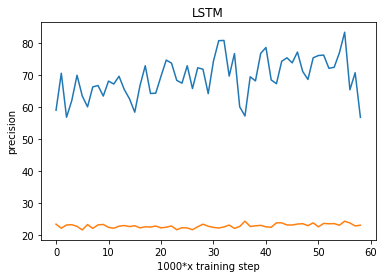

precision of the model on thevalidationdata: 22.6910457611084%
tensor([0.5707, 0.6701, 0.5322, 0.5380, 0.5482, 0.8048, 0.5168, 0.6200, 0.5277,
        0.5552, 0.5070, 0.6215, 0.5865, 0.5236, 0.6906, 0.6026, 0.6770, 0.7879,
        0.7231, 0.6451, 0.5289, 0.6985, 0.5096, 0.5654, 0.7980, 0.5130, 0.7103,
        0.6140, 0.5216, 0.5795, 0.7466, 0.5279, 0.6123, 0.6401, 0.5185, 0.5274,
        0.5122, 0.5099, 0.6112, 0.5758, 0.5115, 0.6377, 0.7076, 0.7452, 0.5572,
        0.6698, 0.5152, 0.6081, 0.5695, 0.5223, 0.8013, 0.5332, 0.6947, 0.6697,
        0.7387, 0.7127, 0.5943, 0.6807, 0.6294, 0.5427, 0.7091, 0.5712, 0.6914,
        0.6374, 0.5294, 0.7403, 0.6151, 0.6005, 0.7406, 0.9997, 0.6018, 0.5189,
        0.7172, 0.5850, 0.6162, 0.8221, 0.7647, 0.8792, 0.5822, 0.5289, 0.6520,
        0.7033, 0.5188, 0.5454, 0.6247, 0.5848, 0.6319, 0.5783, 0.6393, 0.6978,
        0.5047, 0.6699, 0.7592, 0.5776, 0.5796, 0.6368, 0.7222, 0.5028, 0.6784,
        0.5005], device='cuda:1')
current i is 78
Filter 

precision of the model on thevalidationdata: 62.001468658447266%
precision of the model on thetrainingdata: 62.5%
precision of the model on thevalidationdata: 61.374637603759766%
precision of the model on thetrainingdata: 66.19718170166016%
precision of the model on thevalidationdata: 62.71117401123047%
precision of the model on thetrainingdata: 63.82978820800781%
precision of the model on thevalidationdata: 61.564151763916016%


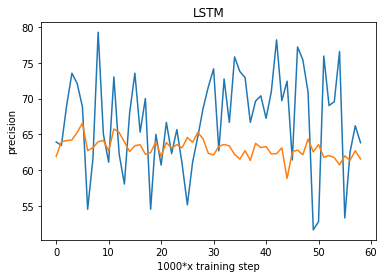

precision of the model on thevalidationdata: 62.74692153930664%
tensor([0.5550, 0.5752, 0.8059, 0.5288, 0.5875, 0.9999, 0.5763, 0.5418, 0.6281,
        0.5994, 0.6048, 0.6629, 0.6043, 0.5853, 0.5626, 0.6662, 0.6370, 0.6551,
        0.5531, 0.6209, 0.5935, 0.5298, 0.5723, 0.6521, 0.5124, 0.5307, 0.6251,
        0.5643, 0.5479, 0.6927, 0.5895, 0.5513, 0.6256, 0.5714, 0.5467, 0.6538,
        0.5137, 0.5291, 0.6257, 0.5879, 0.5423, 0.5599, 0.5878, 0.5501, 0.5519,
        0.6915, 0.6059, 0.5601, 0.5491, 0.6007, 0.5144, 0.6521, 0.6832, 0.5479,
        0.5336, 0.5467, 0.6088, 0.5718, 0.5319, 0.6279, 0.5585, 0.5140, 0.5479,
        0.6661, 0.6017, 0.5543, 0.6100, 0.5316, 0.6791, 0.5478, 0.6143, 0.6007,
        0.5435, 0.6304, 0.7782, 0.5546, 0.5561, 0.5407, 0.5767, 0.5284, 0.5209,
        0.5551, 0.6064, 0.5681, 0.7256, 0.5779, 0.5695, 0.5519, 0.6779, 0.7098,
        0.5934, 0.5077, 0.5348, 0.5530, 0.5013, 0.9785, 0.6080, 0.6423, 0.7173,
        0.5670], device='cuda:1')
current i is 80
Filter

precision of the model on thetrainingdata: 60.344825744628906%
precision of the model on thevalidationdata: 44.596946716308594%
precision of the model on thetrainingdata: 77.33333587646484%
precision of the model on thevalidationdata: 45.27986526489258%


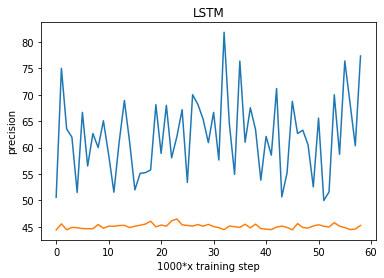

precision of the model on thevalidationdata: 45.16255569458008%
tensor([0.6208, 0.6241, 0.5318, 0.6055, 0.5038, 0.7155, 0.7043, 0.6840, 0.7125,
        0.6748, 0.5673, 0.7318, 0.6011, 0.5637, 0.5372, 0.6476, 0.6850, 0.5010,
        0.5778, 0.7829, 0.5512, 0.6684, 0.6860, 0.5064, 0.5315, 0.6095, 0.5545,
        0.7610, 0.5629, 0.6538, 0.5601, 0.6367, 0.8671, 0.6325, 0.6060, 0.5353,
        0.5038, 0.6729, 0.5644, 0.6145, 0.5820, 0.5623, 0.5893, 0.6987, 0.5545,
        0.6856, 0.7307, 0.6955, 0.6015, 0.6118, 0.7259, 0.5436, 0.6325, 0.5681,
        0.6001, 0.6422, 0.6774, 0.6028, 0.5292, 0.5093, 0.7005, 0.7234, 0.7548,
        0.5853, 0.5280, 0.6690, 0.5225, 0.7874, 0.5184, 0.6557, 0.8241, 0.5257,
        0.7551, 0.6823, 0.6521, 0.6941, 0.6162, 0.6960, 0.5214, 0.5276, 0.5104,
        0.7488, 0.5661, 0.9530, 0.6370, 0.5236, 0.5083, 0.6617, 0.6658, 0.8556,
        0.5073, 0.6154, 0.7834, 0.6322, 0.7411, 0.8155, 0.5532, 0.6627, 0.5836,
        0.6934], device='cuda:1')
current i is 81
Filter

precision of the model on thevalidationdata: 39.60846710205078%
precision of the model on thetrainingdata: 87.67123413085938%
precision of the model on thevalidationdata: 39.069664001464844%
precision of the model on thetrainingdata: 67.30769348144531%
precision of the model on thevalidationdata: 38.87329864501953%
precision of the model on thetrainingdata: 83.87096405029297%
precision of the model on thevalidationdata: 38.97505187988281%


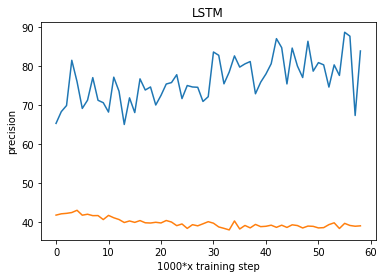

precision of the model on thevalidationdata: 38.63148880004883%
tensor([0.5135, 0.5982, 0.8956, 0.9885, 0.9923, 1.0000, 0.9658, 0.7320, 0.9459,
        0.8442, 0.9943, 0.9427, 0.8050, 0.9460, 0.5255, 0.6047, 0.5202, 0.5709,
        0.7352, 0.5571, 0.5869, 0.7703, 0.6263, 0.8445, 0.7407, 0.6952, 0.5437,
        0.9055, 0.7999, 0.9068, 0.6420, 0.9960, 0.7315, 0.9858, 0.7609, 0.6263,
        0.9435, 0.6765, 0.7537, 0.8791, 0.7615, 0.5070, 0.9141, 0.5980, 0.6338,
        0.7403, 0.9362, 0.9525, 0.9087, 0.5765, 0.7363, 0.7420, 0.7659, 0.9563,
        0.7366, 0.9824, 0.7248, 0.7123, 0.6476, 0.6375, 0.7976, 0.9150, 0.9224,
        0.9984, 0.7555, 0.9924, 0.6533, 0.9217, 0.7075, 0.5026, 0.6986, 0.7665,
        0.8331, 0.5440, 0.7500, 0.8615, 0.7292, 0.9950, 0.9602, 0.7881, 0.5326,
        0.5486, 0.7015, 0.7866, 0.6899, 0.7045, 0.9916, 0.8440, 0.7480, 0.9698,
        0.7004, 0.5012, 0.5523, 0.9994, 0.9968, 0.8154, 0.8602, 0.5583, 0.7042,
        0.5430], device='cuda:1')
current i is 83
Filter

precision of the model on thetrainingdata: 60.71428680419922%
precision of the model on thevalidationdata: 33.37727355957031%
precision of the model on thetrainingdata: 72.97297668457031%
precision of the model on thevalidationdata: 33.4649543762207%


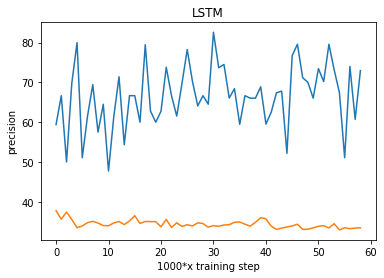

precision of the model on thevalidationdata: 32.63638687133789%
tensor([0.6398, 0.7004, 0.5652, 0.6035, 0.5536, 0.7595, 0.5584, 0.6429, 0.5506,
        0.7499, 0.6701, 0.6408, 0.5311, 0.7737, 0.6402, 0.6718, 0.8354, 0.9208,
        0.6226, 0.8115, 0.5248, 0.5534, 0.8371, 0.7696, 0.7704, 0.9081, 0.6419,
        0.7372, 0.8699, 0.5109, 0.5181, 0.9715, 0.8338, 0.5120, 0.7926, 0.5205,
        0.6310, 0.5853, 0.9004, 0.5110, 0.7218, 0.7801, 0.5218, 0.5840, 0.5423,
        0.5430, 0.7565, 0.8422, 0.6595, 0.7239, 0.5342, 0.6319, 0.6474, 0.6609,
        0.7776, 0.7713, 0.7016, 0.7074, 0.7142, 0.9292, 0.6405, 0.6391, 0.7712,
        0.5320, 0.6549, 0.8460, 0.7946, 0.5587, 0.6701, 0.6297, 0.8040, 0.7482,
        0.6965, 0.8923, 0.7140, 0.8023, 0.6009, 0.5496, 0.8986, 0.5847, 0.5027,
        0.6137, 0.6363, 0.8012, 0.7576, 0.7247, 0.5415, 0.6842, 0.8148, 0.5680,
        0.6820, 0.6155, 0.8497, 0.5480, 0.5455, 0.7492, 0.5002, 0.6759, 0.5717,
        0.5669], device='cuda:1')
current i is 84
Filter

precision of the model on thetrainingdata: 79.4117660522461%
precision of the model on thevalidationdata: 42.21635818481445%
precision of the model on thetrainingdata: 67.5%
precision of the model on thevalidationdata: 42.33261489868164%


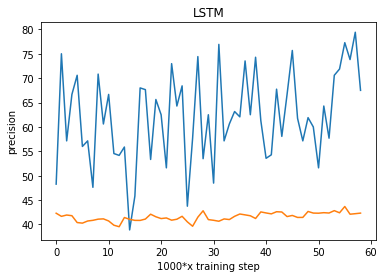

precision of the model on thevalidationdata: 43.784786224365234%
tensor([0.8571, 0.6150, 0.5211, 0.8167, 0.5017, 0.5582, 0.9107, 0.8287, 0.9768,
        0.9233, 0.8501, 0.8740, 0.7207, 0.5307, 0.8127, 0.5465, 0.6005, 0.7956,
        0.8780, 0.5952, 0.5996, 0.5973, 0.5337, 0.8196, 0.7278, 0.8738, 0.5215,
        0.6309, 0.7063, 0.8347, 0.6876, 0.5197, 0.7089, 0.7569, 0.5145, 0.5379,
        0.6348, 0.6358, 0.7105, 0.5669, 0.5012, 0.6585, 0.9679, 0.5141, 0.5545,
        0.5265, 0.6876, 0.9690, 0.8123, 0.5516, 0.5344, 0.7538, 0.5127, 0.7588,
        0.6666, 0.5797, 0.6841, 0.7067, 0.5391, 0.5744, 0.5448, 0.6568, 0.5044,
        0.5577, 0.5704, 0.6656, 0.7528, 0.6186, 0.7253, 0.6129, 0.6220, 0.5521,
        0.7438, 0.5850, 0.5581, 0.6702, 0.6019, 0.5399, 0.5310, 0.5427, 0.6168,
        0.5346, 0.9130, 0.9971, 0.5852, 0.6590, 0.5080, 0.9363, 0.6708, 0.6821,
        0.5798, 0.6277, 0.5847, 0.6682, 0.5126, 0.6713, 0.7325, 0.6038, 0.8422,
        0.8146], device='cuda:1')
current i is 85
Filte

precision of the model on thevalidationdata: 47.81945037841797%
precision of the model on thetrainingdata: 62.5%
precision of the model on thevalidationdata: 46.74285888671875%
precision of the model on thetrainingdata: 68.62744903564453%
precision of the model on thevalidationdata: 46.94623565673828%


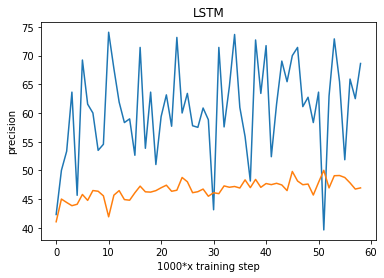

precision of the model on thevalidationdata: 45.87352752685547%
tensor([0.7701, 0.6565, 0.5050, 0.5152, 0.5288, 0.6154, 0.5139, 0.5007, 0.5045,
        0.5123, 0.5303, 0.5382, 0.8252, 0.6625, 0.7219, 0.5979, 0.5733, 0.5188,
        0.5995, 0.6388, 0.5746, 0.6096, 0.5140, 0.5549, 0.5974, 0.5768, 0.7505,
        0.5322, 0.5914, 0.6622, 0.6963, 0.7332, 0.6919, 0.6525, 0.5126, 0.6073,
        0.5361, 0.5235, 0.6177, 0.6073, 0.5747, 0.5199, 0.6009, 0.5656, 0.6861,
        0.6157, 0.5962, 0.6083, 0.7091, 0.5068, 0.5079, 0.5364, 0.6077, 0.6232,
        0.5060, 0.5314, 0.6995, 0.5329, 0.5472, 0.5213, 0.5372, 0.7183, 0.7572,
        0.5969, 0.6885, 0.8763, 0.5306, 0.6676, 0.6494, 0.5066, 0.5164, 0.5123,
        0.5650, 0.7576, 0.5946, 0.6226, 0.5254, 0.5140, 0.5250, 0.5629, 0.5293,
        0.5273, 0.5374, 0.5353, 0.5140, 0.5821, 0.8323, 0.5682, 0.6923, 0.6103,
        0.5141, 0.6923, 0.7529, 0.5527, 0.6826, 0.5836, 0.7031, 0.8671, 0.5789,
        0.6330], device='cuda:1')
current i is 86
Filter

precision of the model on thevalidationdata: 41.583858489990234%
precision of the model on thetrainingdata: 56.140350341796875%
precision of the model on thevalidationdata: 42.76422882080078%
precision of the model on thetrainingdata: 60.0%
precision of the model on thevalidationdata: 42.01183319091797%


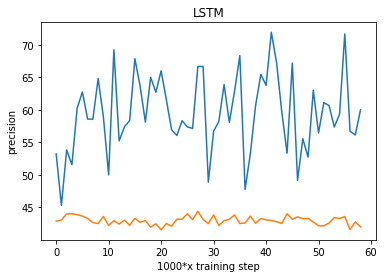

precision of the model on thevalidationdata: 42.96197509765625%
tensor([0.5622, 0.6731, 0.6154, 0.5511, 0.7413, 0.6072, 0.5762, 0.6208, 0.7781,
        0.9432, 0.5336, 0.6254, 0.5100, 0.5168, 0.5230, 0.5920, 0.9584, 0.6960,
        0.8878, 0.8073, 0.5813, 0.5869, 0.5857, 0.6124, 0.5650, 0.6969, 0.5884,
        0.9970, 0.5754, 0.6658, 0.6050, 0.6484, 0.5631, 0.5856, 0.5366, 0.5212,
        0.7632, 0.5268, 0.5876, 0.6630, 0.9339, 0.9947, 0.8616, 0.5998, 0.7182,
        0.9004, 0.5774, 0.6483, 0.5368, 0.5719, 0.5874, 0.6117, 0.6580, 0.6025,
        0.5081, 0.5618, 0.8451, 0.7090, 0.5151, 0.6904, 0.5406, 0.9976, 0.5431,
        0.5012, 0.5657, 0.5745, 0.7885, 0.9500, 0.8696, 0.5465, 0.5195, 0.5697,
        0.5457, 0.6421, 0.9615, 0.5552, 0.5360, 0.5352, 0.5714, 0.6263, 0.6110,
        0.8643, 0.5446, 0.7886, 0.6445, 0.9852, 0.6512, 0.5254, 0.5184, 0.7055,
        0.9260, 0.5121, 0.5413, 0.5029, 0.5211, 0.5345, 0.6653, 0.5610, 0.5280,
        0.5695], device='cuda:1')
current i is 87
Filter

precision of the model on thetrainingdata: 75.0%
precision of the model on thevalidationdata: 53.38482666015625%
precision of the model on thetrainingdata: 76.0%
precision of the model on thevalidationdata: 51.649269104003906%


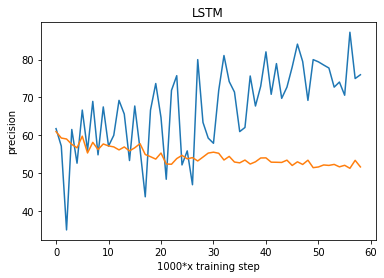

precision of the model on thevalidationdata: 53.310447692871094%
tensor([0.8877, 0.6781, 0.5129, 0.6376, 0.5938, 0.7004, 0.9122, 0.9164, 0.8807,
        0.6942, 0.8300, 0.6299, 0.6333, 0.6161, 0.5088, 0.6909, 0.5511, 0.6017,
        0.5922, 0.9864, 0.7785, 0.6095, 0.8467, 0.8720, 0.6026, 0.6978, 0.7130,
        0.7014, 0.8595, 0.9725, 0.6318, 0.8810, 0.9230, 0.6761, 0.9993, 0.8619,
        0.9674, 0.5475, 0.6478, 0.9212, 0.9056, 0.5857, 0.9732, 0.7143, 0.7285,
        0.6662, 0.7022, 0.9644, 0.7425, 0.6336, 0.7499, 0.8002, 0.8268, 0.7745,
        0.5040, 0.5517, 0.8822, 0.5317, 0.8102, 0.9964, 0.9861, 0.9999, 0.7987,
        0.7482, 0.7713, 0.9775, 0.6674, 0.6180, 0.5064, 0.9998, 0.6100, 0.5266,
        0.7038, 0.7120, 0.8069, 0.5515, 0.9849, 0.9903, 0.5288, 0.9976, 0.8594,
        0.7798, 0.8563, 0.6771, 0.5901, 0.7826, 0.8943, 0.6759, 0.8983, 0.8082,
        0.9159, 0.9623, 0.9691, 0.6376, 1.0000, 0.7036, 0.8113, 0.6191, 0.7452,
        0.7881], device='cuda:1')
current i is 88
Filte

precision of the model on thetrainingdata: 82.75862121582031%
precision of the model on thevalidationdata: 45.7369270324707%


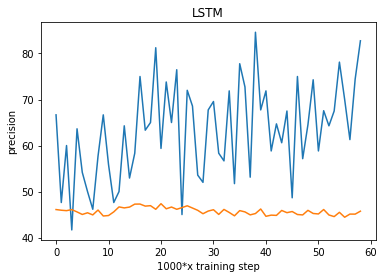

precision of the model on thevalidationdata: 45.26969909667969%
tensor([0.9807, 0.9608, 0.9949, 0.5009, 0.6102, 0.5468, 0.9318, 0.7625, 0.9812,
        0.7593, 0.6543, 0.5452, 0.6407, 0.6940, 0.5652, 0.9050, 0.9945, 0.9512,
        0.8819, 0.9325, 0.9381, 0.8989, 0.5989, 0.9128, 0.9838, 0.9862, 0.9162,
        0.6005, 0.5524, 0.5582, 0.7621, 0.7180, 0.6397, 0.9124, 0.5176, 0.7223,
        0.5279, 0.6909, 0.6519, 0.8596, 0.9796, 0.7584, 0.5782, 0.7034, 0.6146,
        0.8922, 0.8224, 0.5602, 0.8700, 0.7263, 0.7439, 0.9423, 0.5185, 0.5229,
        0.5536, 0.6642, 0.7989, 0.7560, 0.6954, 0.6789, 0.5553, 0.6741, 0.8889,
        0.5602, 0.6425, 0.7415, 0.9946, 0.5775, 0.5700, 0.6335, 0.6175, 0.8566,
        0.8459, 0.6800, 0.6562, 0.9934, 0.5361, 0.6477, 0.7768, 0.9587, 0.5731,
        0.9167, 0.6359, 0.9955, 0.7755, 0.8561, 0.5384, 0.8431, 0.8648, 0.8690,
        0.8495, 0.6205, 0.9141, 0.5450, 0.6271, 0.5853, 0.5385, 0.6256, 0.6747,
        0.5093], device='cuda:1')
current i is 89
Filter

precision of the model on thetrainingdata: 63.934425354003906%
precision of the model on thevalidationdata: 55.27815628051758%
precision of the model on thetrainingdata: 68.62744903564453%
precision of the model on thevalidationdata: 57.36308288574219%


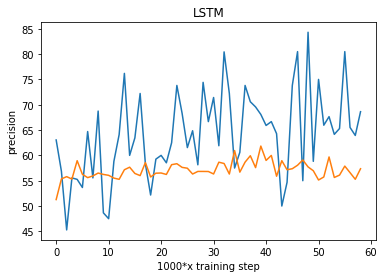

precision of the model on thevalidationdata: 56.490135192871094%
tensor([0.7803, 0.5693, 0.5478, 0.6197, 0.6055, 0.5852, 0.6731, 0.5546, 0.6567,
        0.5317, 0.5761, 0.6129, 0.6604, 0.5059, 0.5148, 0.6953, 0.6150, 0.6616,
        0.5445, 0.6868, 0.7344, 0.7356, 0.6172, 0.7494, 0.5022, 0.5752, 0.5803,
        0.6546, 0.6346, 0.7178, 0.5346, 0.6274, 0.5782, 0.5166, 0.8300, 0.5469,
        0.7639, 0.5720, 0.5425, 0.6733, 0.5503, 0.6181, 0.6864, 0.5542, 0.5424,
        0.6398, 0.5310, 0.7132, 0.7472, 0.6005, 0.5778, 0.5851, 0.5765, 0.6860,
        0.7394, 0.6518, 0.7794, 0.5073, 0.6816, 0.6354, 0.6816, 0.5345, 0.5174,
        0.5252, 0.5900, 0.9024, 0.5431, 0.6824, 0.6900, 0.6792, 0.5939, 0.5166,
        0.5597, 0.5818, 0.6802, 0.5612, 0.6068, 0.5694, 0.6680, 0.5013, 0.5483,
        0.5937, 0.5585, 0.5950, 0.6350, 0.6425, 0.5690, 0.6635, 0.6793, 0.6456,
        0.6198, 0.5606, 0.5610, 0.5202, 0.5311, 0.6110, 0.5036, 0.7105, 0.5781,
        0.5728], device='cuda:1')


In [12]:
result = wavenet_rolling_window(df_train_dict, df_valid_dict)

In [13]:
def transform_dict_to_df(result):
    result_df_dict={}
    for i in result.keys():
        valid_index_list, score, predicted, train_label_list = result[str(i)]
        first = np.array(valid_index_list)[:,0].reshape(-1,)
        second = np.array(valid_index_list)[:,1].reshape(-1,)
        third = score.cpu().reshape(-1,1).reshape(-1,)
        fourth = train_label_list.reshape(-1,)
        fifth = predicted.reshape(-1,) 
        third = np.array(third)
        fifth = np.array(fifth.cpu())
        data = np.array([first,second,third,fourth,fifth])
        data = np.transpose(data, (1,0))
        result_df_dict[str(i)] = pd.DataFrame(data=data, columns=['date','index','score','label','prediction'])
    return result_df_dict

In [14]:
result_df_dict = transform_dict_to_df(result)

In [15]:
def pre_processing(result_df_dict):
    processed = {}
    for i in result_df_dict.keys():
        print(i)
        df = result_df_dict[str(i)]
        df['prediction'] = df['prediction'].astype('float64')
        df['label'] = df['label'].astype('float64')
        df['score'] = df['score'].astype('float64')
        idx = df[df['prediction']==0].index
        df.loc[idx,'score'] = 1-df.loc[idx,'score']
        print(df)
        processed[str(i)] = df
    return processed

In [16]:
processed = pre_processing(result_df_dict)

1
            date      index         score  label  prediction
0     2013-03-14  000001.SZ  2.636912e-01    1.0         0.0
1     2013-03-15  000001.SZ  9.614932e-01    0.0         1.0
2     2013-03-18  000001.SZ  5.342388e-01    0.0         1.0
3     2013-03-14  000002.SZ  4.254967e-01    0.0         0.0
4     2013-03-15  000002.SZ  5.132918e-01    1.0         1.0
...          ...        ...           ...    ...         ...
6993  2013-03-15  603399.SH  9.378030e-01    0.0         1.0
6994  2013-03-18  603399.SH  2.824997e-01    1.0         0.0
6995  2013-03-14  603766.SH  5.000000e-07    1.0         0.0
6996  2013-03-15  603766.SH  1.000000e+00    0.0         1.0
6997  2013-03-18  603766.SH  9.514153e-02    1.0         0.0

[6998 rows x 5 columns]
2
            date      index     score  label  prediction
0     2013-04-15  000001.SZ  0.000444    0.0         0.0
1     2013-04-15  000002.SZ  0.987808    1.0         1.0
2     2013-04-15  000004.SZ  0.459058    0.0         0.0
3     2013-

            date      index     score  label  prediction
0     2014-11-20  000001.SZ  0.000381    0.0         0.0
1     2014-11-21  000001.SZ  0.950057    0.0         1.0
2     2014-11-24  000001.SZ  0.296141    1.0         0.0
3     2014-11-20  000002.SZ  0.213862    0.0         0.0
4     2014-11-21  000002.SZ  0.101876    1.0         0.0
...          ...        ...       ...    ...         ...
6512  2014-11-21  603699.SH  0.000563    0.0         0.0
6513  2014-11-24  603699.SH  0.308252    0.0         0.0
6514  2014-11-20  603993.SH  0.624612    0.0         1.0
6515  2014-11-21  603993.SH  0.658391    1.0         1.0
6516  2014-11-24  603993.SH  0.519427    1.0         1.0

[6517 rows x 5 columns]
24
            date      index     score  label  prediction
0     2014-12-18  000001.SZ  0.184704    0.0         0.0
1     2014-12-19  000001.SZ  0.370545    1.0         0.0
2     2014-12-22  000001.SZ  0.237904    0.0         0.0
3     2014-12-18  000002.SZ  0.301472    0.0         0.0
4  

35
            date      index     score  label  prediction
0     2015-10-22  000001.SZ  0.378976    1.0         0.0
1     2015-10-23  000001.SZ  0.667075    1.0         1.0
2     2015-10-26  000001.SZ  0.964976    0.0         1.0
3     2015-10-22  000002.SZ  0.899602    1.0         1.0
4     2015-10-23  000002.SZ  0.705060    0.0         1.0
...          ...        ...       ...    ...         ...
6147  2015-10-23  603997.SH  0.000502    0.0         0.0
6148  2015-10-26  603997.SH  0.908485    0.0         1.0
6149  2015-10-22  603998.SH  0.450681    1.0         0.0
6150  2015-10-23  603998.SH  0.157285    0.0         0.0
6151  2015-10-26  603998.SH  0.633293    0.0         1.0

[6152 rows x 5 columns]
36
            date      index     score  label  prediction
0     2015-11-19  000001.SZ  0.569004    1.0         1.0
1     2015-11-20  000001.SZ  0.606889    0.0         1.0
2     2015-11-23  000001.SZ  0.716402    0.0         1.0
3     2015-11-19  000002.SZ  0.287313    0.0         0.0


            date      index     score  label  prediction
0     2017-07-27  000001.SZ  0.460300    1.0         0.0
1     2017-07-28  000001.SZ  0.003179    0.0         0.0
2     2017-07-31  000001.SZ  0.031299    1.0         0.0
3     2017-07-28  000002.SZ  1.000000    0.0         1.0
4     2017-07-31  000002.SZ  0.770014    0.0         1.0
...          ...        ...       ...    ...         ...
8165  2017-07-28  603998.SH  0.334559    0.0         0.0
8166  2017-07-31  603998.SH  0.486316    0.0         0.0
8167  2017-07-27  603999.SH  0.187447    0.0         0.0
8168  2017-07-28  603999.SH  0.428331    0.0         0.0
8169  2017-07-31  603999.SH  0.326084    0.0         0.0

[8170 rows x 5 columns]
59
            date      index     score  label  prediction
0     2017-08-24  000001.SZ  0.518248    0.0         1.0
1     2017-08-25  000001.SZ  0.352829    1.0         0.0
2     2017-08-28  000001.SZ  0.651225    1.0         1.0
3     2017-08-24  000002.SZ  0.659956    0.0         1.0
4  

            date      index     score  label  prediction
0     2019-01-14  000001.SZ  0.429319    0.0         0.0
1     2019-01-14  000002.SZ  0.670134    0.0         1.0
2     2019-01-14  000004.SZ  0.532184    0.0         1.0
3     2019-01-14  000005.SZ  0.462046    0.0         0.0
4     2019-01-14  000006.SZ  0.548232    0.0         1.0
...          ...        ...       ...    ...         ...
3466  2019-01-14  603993.SH  0.395811    0.0         0.0
3467  2019-01-14  603996.SH  0.599905    0.0         1.0
3468  2019-01-14  603997.SH  0.541124    0.0         1.0
3469  2019-01-14  603998.SH  0.541803    0.0         1.0
3470  2019-01-14  603999.SH  0.656006    0.0         1.0

[3471 rows x 5 columns]
79
             date      index     score  label  prediction
0      2019-03-07  000001.SZ  0.444957    1.0         0.0
1      2019-03-08  000001.SZ  0.424801    0.0         0.0
2      2019-03-11  000001.SZ  0.194099    0.0         0.0
3      2019-03-07  000002.SZ  0.528806    0.0         1.

In [17]:
def sort_top_k(result_df_dict,k):
    top_k_df={}
    for i in result_df_dict.keys():
        #print(i)
        temp = result_df_dict[str(i)].sort_values('score', axis=0, ascending=False).groupby(by = 'date').head(k)
        #print(temp)
        top_k_df[str(i)] = temp
    return top_k_df

In [18]:
def precision_top_k(head):
    pre=[]
    for i in head.keys():
        pre.append(sum(head[str(i)]['label']*head[str(i)]['prediction'])/sum(head[str(i)]['prediction']))
    return pre

In [21]:
def mult_k(processed,k):
    pre_dict={}
    for i in k:
        print(i)
        head = sort_top_k(processed,i)
        pre_dict[str(i)]=precision_top_k(head)
    for i in k:
        plt.plot(pre_dict[str(i)],label='top'+str(i))
        plt.legend()
    plt.ylabel('precision')
    plt.show()
    return pre_dict

10
20
40
80
160
320
640
1280
100000


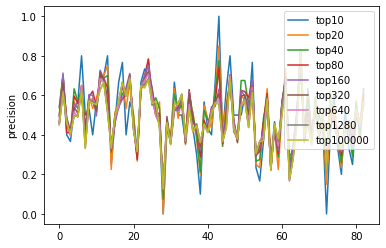

In [22]:
precision_diction = mult_k(processed,[10,20,40,80,160,320,640,1280,100000])

In [23]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.4889558232931727
top20 mean precision: 0.49337349397590363
top40 mean precision: 0.5019076305220885
top80 mean precision: 0.5000502008032129
top160 mean precision: 0.49500502008032127
top320 mean precision: 0.4910869925096535
top640 mean precision: 0.4842984283970373
top1280 mean precision: 0.480602860362109
top100000 mean precision: 0.4802767205032915
